<div class = "alert alert-block alert-info">
    <center> <h1> Clustering Analysis of Insurance Data</h1> 
        <h3>Group BB</h3></center>

<br>
<center>
Catarina Natário Moreira,  m20201034@novaims.unl.pt <BR>
Miguel Lince, m20211300@novaims.unl.pt

**Table of Contents:** <br>
* [1) Imports](#imports)
    * [1.1) Import packages](#imppkg)
    * [1.2) Import data](#impdata)
* [2) Data exploration](#explor)
    * [2.1) Categorical features](#catfeat)
    * [2.2) Numerical features](#numfeat)
        * [2.2.1) Plots](#plots)
        * [2.2.2) Correlation](#corr)
* [3) Data preparation](#preparation)
    * [3.1) Duplicates](#dups)
    * [3.2) Outliers](#outliers)
        * [3.2.1) IQR](#iqr)
        * [3.2.2) Manual filtering](#manfilt)
    * [3.3) Missing values](#missings)
* [4) Data pre-processing](#preprocess)
    * [4.1) Feature engineering](#feateng)
    * [4.2) Standardization](#stand)
* [5) Clustering](#clust)
    * [5.1) DBSCAN](#dbscan)
    * [5.2) Product segmentation](#prodseg)
    * [5.3) Value segmentation](#valueseg)
    * [5.4) Demographic segmentation](#demoseg)
        * [5.4.1) Encoding categorical features](#encod)
    * [5.5) Merging the clusters](#merge)
        * [5.5.1) Profilling](#prof)
    * [6) Reclassify the outliers](#reclass)

<hr>
<a class="anchor" id="imports">
    
# 1) Imports
    
</a>

<hr>
<a class="anchor" id="imppkg">
    
## 1.1) Import packages
    
</a>

In [443]:
# install if needed
# !pip install kmodes
!pip install umap-learn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=e6a446a362473f0d98eccd3db5c412c04cfccd6e99a603383aed06772ee92dcc
  Stored in directory: c:\users\u86004\appdata\local\pip\cache\wheels\f2\64\75\df601da9514261c8cb0830b9515d2b94b5a51f09ddeae92b9e
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=4fa2af81ff6dec0541fc0b90dfd79762fbe335b89acf938aa55425226eab0d60
  Stored in directory: c:\users\u86004\appdata\local\pip\cache\wheels\e4\0e\b5\07c0c231aacb04e5d1046fe7459bb27ea79f95b5edbe88e435
Successfully built umap-learn pynndescent
  Using cached umap_learn-0.5.2-py3-none-any.whl
  Using cached pynndescent-0.5.5-py3-none-any.whl


In [523]:
#To import libraries that we will need in the project
import os
import pandas as pd
import numpy as np
import math
from math import ceil
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.cluster import KMeans, DBSCAN, estimate_bandwidth, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.manifold import MDS
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

plt.style.use("seaborn")

import warnings
warnings.filterwarnings('ignore')

<hr>
<a class="anchor" id="impdata">
    
## 1.2) Import data
    
</a>

Firstly, we start to import the sas table to a pandas dataframe:

In [70]:
#To import the sas data for exploration
dataset = pd.read_sas('../data/a2z_insurance.sas7bdat')

In [71]:
#To return the first 5 rows and to check the data
dataset.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [72]:
#To convert CustID (float) to int  
dataset.CustID = dataset.CustID.astype(int)
#To set CustID as the index for the dataset
dataset.set_index('CustID', inplace=True)

<hr>
<a class="anchor" id="explor">
    
# 2) Data exploration
    
</a>

In [73]:
#To create a new dataset to maintain the original
data_exp = dataset.copy()

In [74]:
##To create two variables that will allow to explore better the data: client tenure and age
data_exp['ClientTenure'] = 2016-data_exp['FirstPolYear']
data_exp['ClientAge'] = 2016-data_exp['BirthYear']

data_exp.drop(columns=['FirstPolYear','BirthYear'], inplace=True)

In [68]:
data_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10257.0,2506.618699,1157.518390,333.00,1706.00,2502.00,3290.00,55215.00
GeoLivArea,10292.0,2.709483,1.266284,1.00,1.00,3.00,4.00,4.00
Children,10272.0,0.706776,0.455263,0.00,0.00,1.00,1.00,1.00
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20
PremMotor,10293.0,299.509328,212.288261,0.00,190.26,298.39,407.52,11604.42
PremHousehold,10293.0,213.484737,350.600857,0.00,49.45,132.80,290.05,25048.80
PremHealth,10293.0,170.836708,296.031245,0.00,110.91,162.03,218.93,28272.00
PremLife,10293.0,41.619221,47.249565,0.00,9.89,25.45,57.01,398.30
PremWork,10293.0,41.343280,51.088703,0.00,10.00,25.56,56.01,1988.70


In [19]:
data_exp.describe(include='O').T

,count,unique,top,freq
EducDeg,10276,4,b'3 - BSc/MSc',4799


###### Regarding numeric variables: 
- There is someone that earn 55 215 per month<br>
- ~71% of the clients have children<br>
- Age has a max of 988 years<br>
- Client tenure has a min of -51 768 yrs<br>
- There are clients with negative premiums<br>
- one client has 256% of claim rate, a really bad client


###### Regarding categorical variables: 
- The academic Degree more frequent is: BSc/MSc

In [6]:
#To check NaN values after creating the 2 new variables
data_exp.isna().sum()

EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
ClientTenure      30
ClientAge         17
dtype: int64

As we can observe, there are some nulls for the premium variables: PremMotor, PremHousehold, PremHealth, Premlife and PremWork.<br>
We will treat this ones now and the others we will analyse them further ahead.

We checked that there are clients with negative premiums and this may mean they canceled a policy in the previous year.
Because we don't know if they canceled or not we will put these values equal to zero.

In [75]:
#To create 5 aux new columns and mark the negative values 
data_exp['MotorCancelled'] = np.where(data_exp['PremMotor']<0,1,0)
data_exp['HomeCancelled'] = np.where(data_exp['PremHousehold']<0,1,0)
data_exp['HealthCancelled'] = np.where(data_exp['PremHealth']<0,1,0)
data_exp['LifeCancelled'] = np.where(data_exp['PremLife']<0,1,0)
data_exp['WorkCancelled'] = np.where(data_exp['PremWork']<0,1,0)

#To create a new column with the total number of negative values 
data_exp['TotalCancelled'] = data_exp['MotorCancelled']+data_exp['HomeCancelled']+data_exp['HealthCancelled']+data_exp['LifeCancelled']+data_exp['WorkCancelled']

#To create a binary column - 1 if policy was canceled and 0 otherwise 
data_exp['Cancelled'] = np.where(data_exp['TotalCancelled']>0,1,0)
                                                                                           
#To replaces negative values for zeros
data_exp['PremMotor'] = np.where(data_exp['PremMotor']<0,0,data_exp['PremMotor'])
data_exp['PremHousehold'] = np.where(data_exp['PremHousehold']<0,0,data_exp['PremHousehold'])
data_exp['PremHealth'] = np.where(data_exp['PremHealth']<0,0,data_exp['PremHealth'])
data_exp['PremLife'] = np.where(data_exp['PremLife']<0,0,data_exp['PremLife'])
data_exp['PremWork'] = np.where(data_exp['PremWork']<0,0,data_exp['PremWork'])

#We will consider that premiums missing is because client does not own the product
data_exp['PremMotor'].fillna(0, inplace=True)
data_exp['PremHousehold'].fillna(0, inplace=True)
data_exp['PremHealth'].fillna(0, inplace=True)
data_exp['PremLife'].fillna(0, inplace=True)
data_exp['PremWork'].fillna(0, inplace=True)

In [39]:
data_exp.isna().sum()

EducDeg            17
MonthSal           36
GeoLivArea          1
Children           21
CustMonVal          0
ClaimsRate          0
PremMotor           0
PremHousehold       0
PremHealth          0
PremLife            0
PremWork            0
ClientTenure       30
ClientAge          17
MotorCancelled      0
HomeCancelled       0
HealthCancelled     0
LifeCancelled       0
WorkCancelled       0
TotalCancelled      0
Cancelled           0
dtype: int64

In [76]:
#To drop the aux columns
data_exp.drop(columns=['MotorCancelled','HomeCancelled','HealthCancelled','LifeCancelled','WorkCancelled'], inplace=True)

In [77]:
data_exp.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
1,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,31.0,34.0,0,0
2,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,35.0,21.0,0,0
3,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,25.0,46.0,0,0
4,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,26.0,35.0,0,0
5,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,30.0,43.0,0,0


Before we start analyzing the data, we decided to have a first look to the correlations. In this way, we can understand each variables, and we can start have an idea which variables we should or not to use in segmentation. It is also possible to understand the dimensions we want to use in the segmentation (not too correlated but not completly independent)

In [78]:
#To define 2 lists: 1 with metric features, another with non metric features
class_features = ['EducDeg', 'GeoLivArea', 'Children', 'Cancelled']
metric_features = list(data_exp.columns[~data_exp.columns.isin(class_features)])

In [79]:
#To check non metric features
print(class_features)

['EducDeg', 'GeoLivArea', 'Children', 'Cancelled']


In [80]:
#To check metric features
print(metric_features)

['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'ClientTenure', 'ClientAge', 'TotalCancelled']


<hr>
<a class="anchor" id="catfeat">
    
## 2.1) Categorical features
    
</a>

In [29]:
data_exp[class_features].head()

,EducDeg,GeoLivArea,Children,Cancelled
CustID,,,,
1,b'2 - High School',1.0,1.0,0
2,b'2 - High School',4.0,1.0,0
3,b'1 - Basic',3.0,0.0,0
4,b'3 - BSc/MSc',4.0,1.0,0
5,b'3 - BSc/MSc',4.0,1.0,0


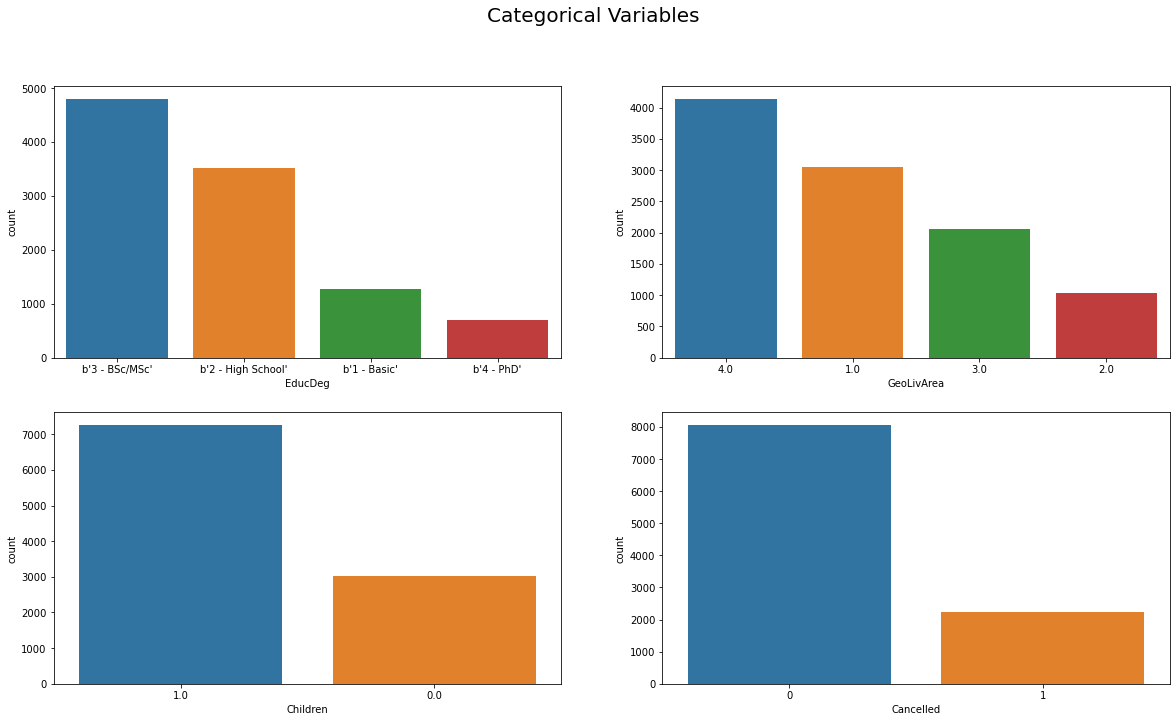

In [37]:
# # Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(class_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), class_features): # Notice the zip() function and flatten() method
    sns.countplot(x=data_exp[feat], order = data_exp[feat].value_counts().index, ax=ax)
    #ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Categorical Variables"
plt.suptitle(title, fontsize=20)
plt.show()

<hr>
<a class="anchor" id="numfeat">
    
## 2.2) Numerical features
    
</a>

In [14]:
#Dataframe with metric_features
data_exp[metric_features].head()

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled
CustID,,,,,,,,,,,
1,2177.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,31.0,34.0,0
2,677.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,35.0,21.0,0
3,2277.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,25.0,46.0,0
4,1099.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,26.0,35.0,0
5,1763.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,30.0,43.0,0


<hr>
<a class="anchor" id="plots">
    
### 2.2.1) Plots
    
</a>

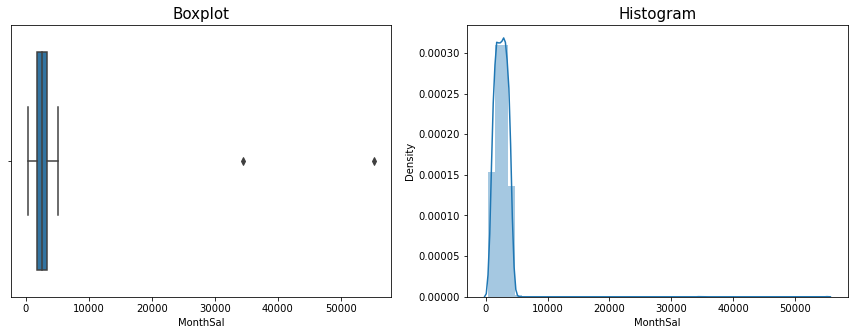

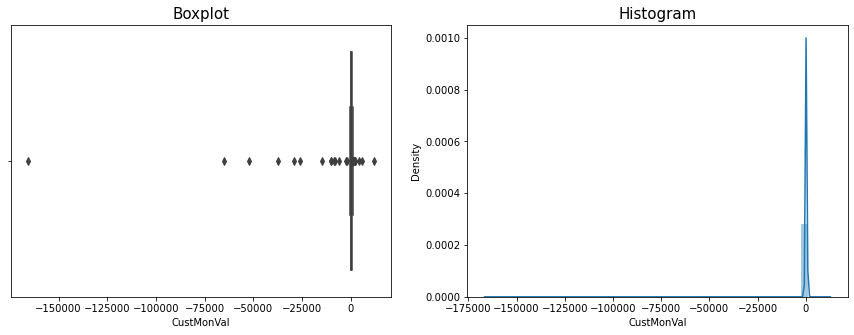

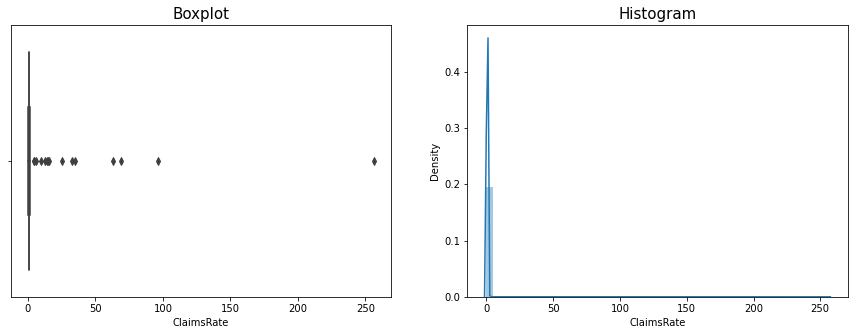

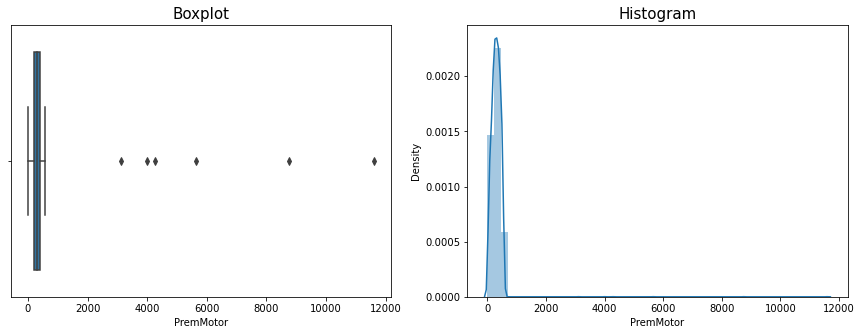

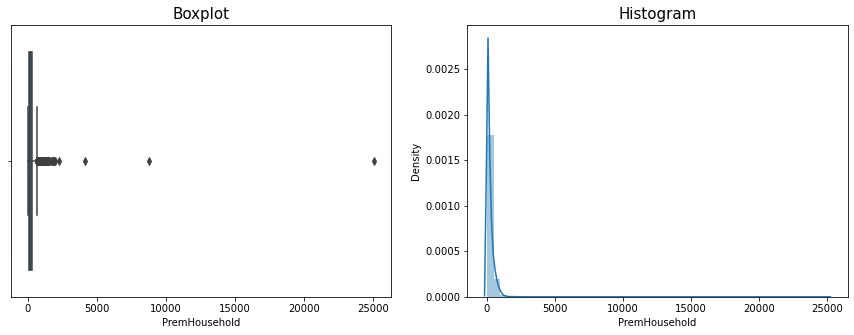

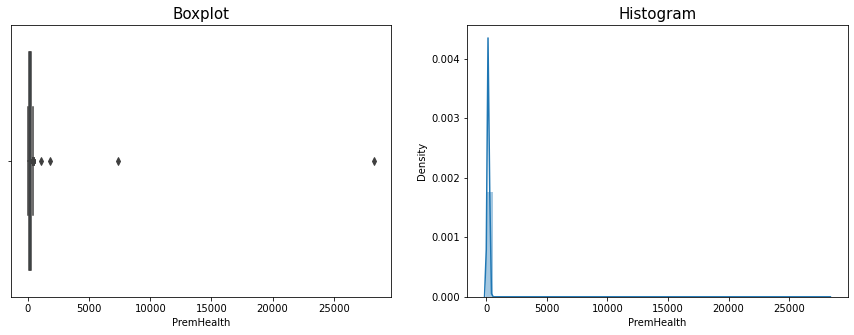

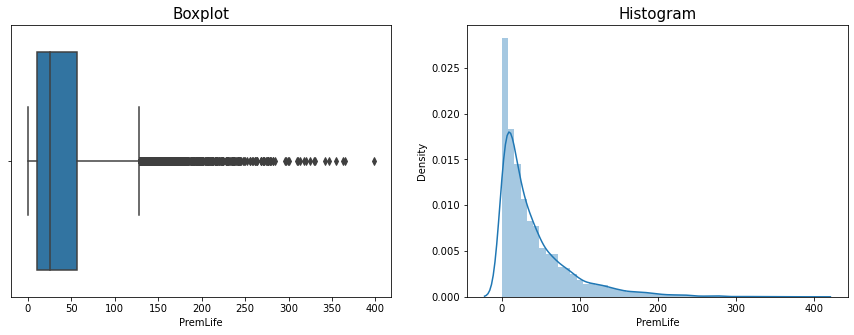

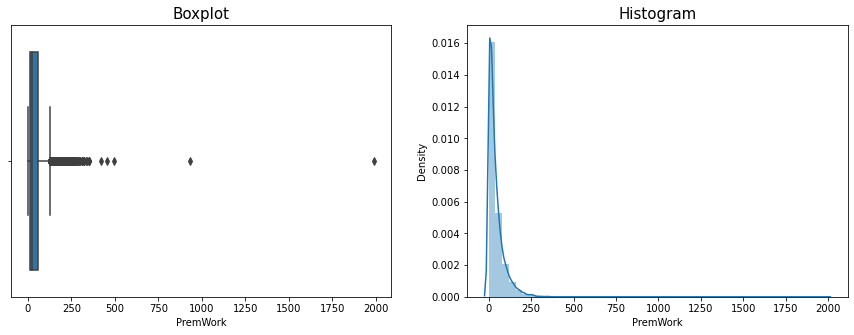

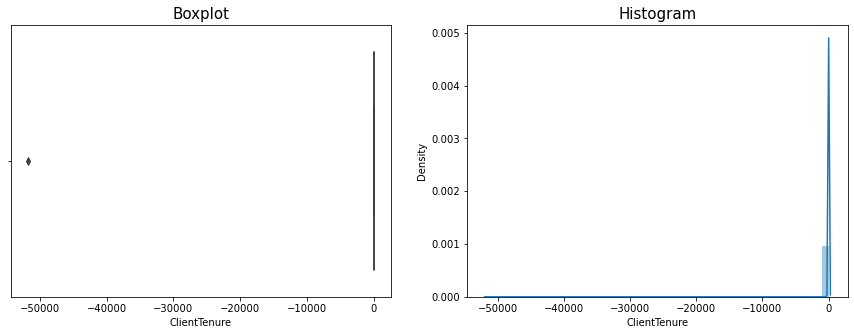

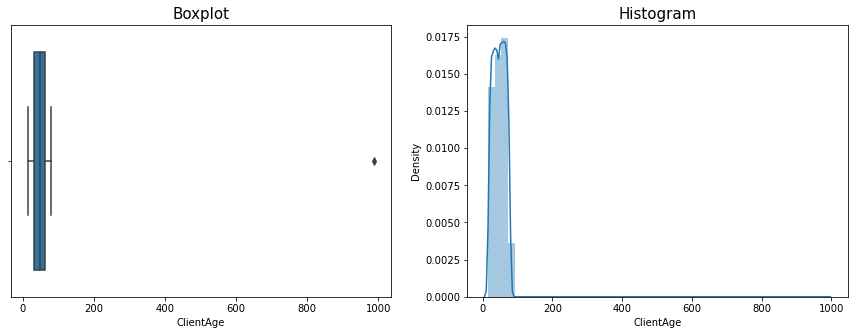

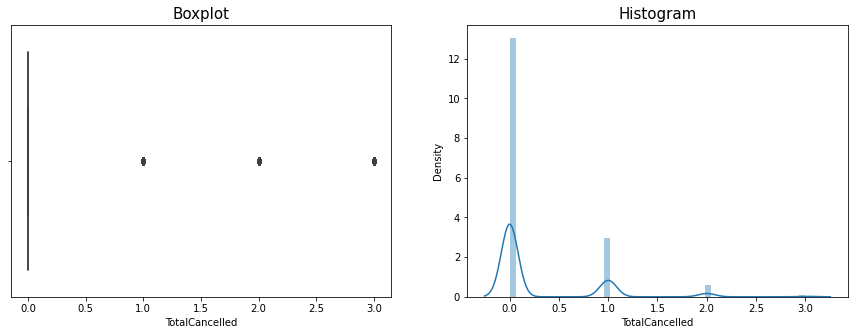

In [40]:
#Single Metric variable boxplot and distribuition plot

for feat in metric_features:
    
    f, axs = plt.subplots(2,2,figsize=(15,5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data_exp[feat])
    plt.title('Boxplot', fontsize = 15)


    plt.subplot(1, 2, 2)
    sns.distplot(x=data_exp[feat])
    plt.title('Histogram', fontsize = 15)

    plt.xlabel(feat)
    plt.show()

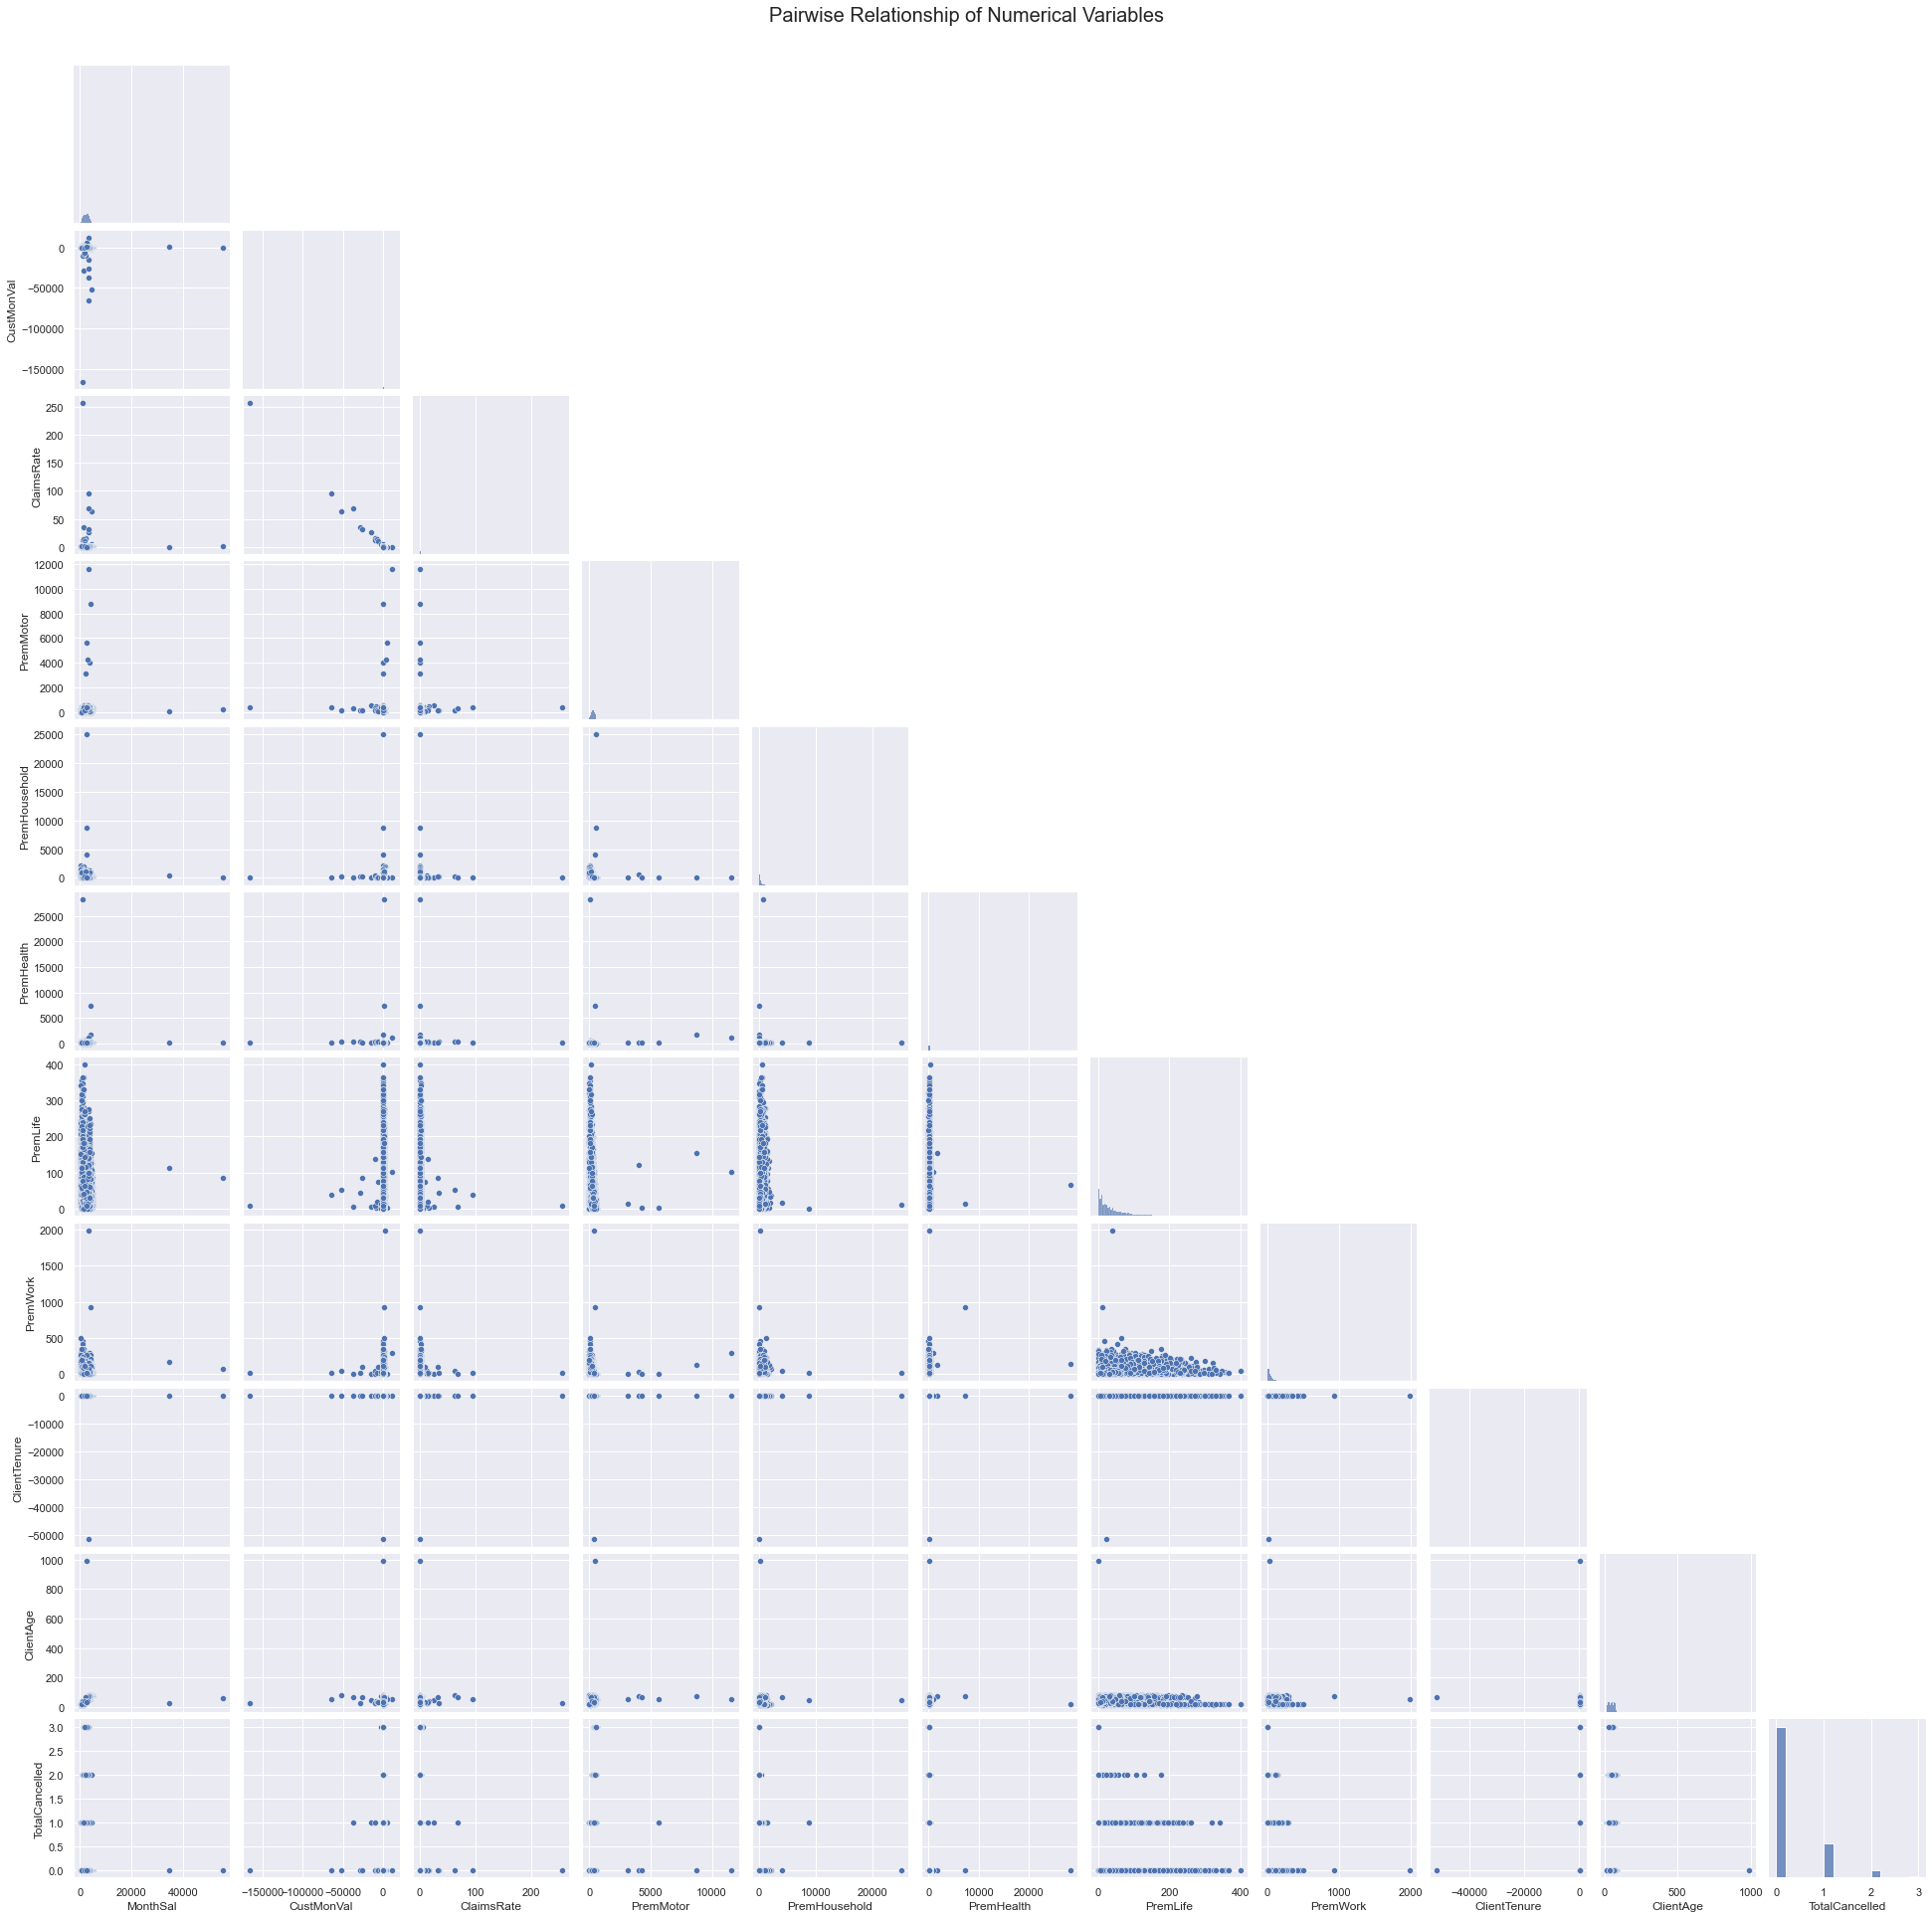

In [41]:
#To understand the relationship of the numerical variables
#Pairwise Relationship of Numerical Variables
sns.set()

#Setting pairplot
sns.pairplot(data_exp[metric_features], diag_kind="hist", corner = True)

#Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

<hr>
<a class="anchor" id="corr">
    
### 2.2.2) Correlation
    
</a>

In [64]:
#Now we are checking the correlation between the variables
def correlation(df, threshold):   
    #To obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
    corre = round(df[metric_features].corr(),2)

    #To build annotation matrix (values above |threshold| will appear annotated in the plot)
    mask_annot = np.absolute(corre.values) >= threshold
    annot = np.where(mask_annot, corre.values, np.full(corre.shape,""))
    
    mask = np.triu(np.ones_like(corre, dtype=bool))
    
    
    #To prepare figure
    fig = plt.figure(figsize=(12, 10))

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corre, annot=annot, mask = mask,cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    #fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    plt.show()

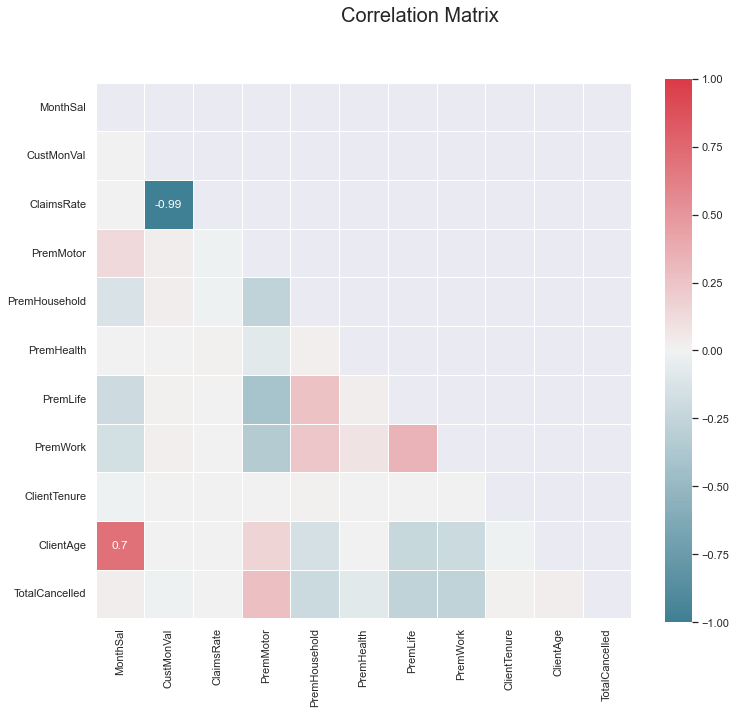

In [66]:
correlation(data_exp, 0.7)

**Here, we will consider Pearson correlation and we set a threshold of |0.7|. From this correlation we can take:**
- Client age and Monthly salary are obviously correlated but we will keep both for now
- Claims rate and customer value have a perfect correlation and are not really correlated with any variable else
- Client tenure is not correlated with any other variables
- Premium variables, MonthSal, Age and TotalCancelled are the variables kind of correlated with each other

In [67]:
#To use perarson correlation
round(data_exp[metric_features].corr(),2)

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled
MonthSal,1.00,-0.00,-0.00,0.14,-0.13,-0.00,-0.20,-0.17,-0.01,0.70,0.03
CustMonVal,-0.00,1.00,-0.99,0.03,0.03,0.00,0.01,0.02,-0.00,-0.00,-0.01
ClaimsRate,-0.00,-0.99,1.00,-0.01,-0.01,0.01,0.00,-0.00,0.00,-0.00,-0.00
PremMotor,0.14,0.03,-0.01,1.00,-0.27,-0.08,-0.41,-0.34,-0.00,0.16,0.28
PremHousehold,-0.13,0.03,-0.01,-0.27,1.00,0.02,0.26,0.24,0.01,-0.15,-0.21
PremHealth,-0.00,0.00,0.01,-0.08,0.02,1.00,0.03,0.08,-0.00,-0.00,-0.08
PremLife,-0.20,0.01,0.00,-0.41,0.26,0.03,1.00,0.34,0.00,-0.23,-0.27
PremWork,-0.17,0.02,-0.00,-0.34,0.24,0.08,0.34,1.00,0.00,-0.21,-0.27
ClientTenure,-0.01,-0.00,0.00,-0.00,0.01,-0.00,0.00,0.00,1.00,-0.01,0.01
ClientAge,0.70,-0.00,-0.00,0.16,-0.15,-0.00,-0.23,-0.21,-0.01,1.00,0.03


<hr>
<a class="anchor" id="preparation">
    
# 3) Data preparation
    
</a>

In [68]:
#To chekc the data types of the columns and to see the transformations can be done in dataset
data_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10296 entries, 1 to 10296
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EducDeg         10279 non-null  object 
 1   MonthSal        10260 non-null  float64
 2   GeoLivArea      10295 non-null  float64
 3   Children        10275 non-null  float64
 4   CustMonVal      10296 non-null  float64
 5   ClaimsRate      10296 non-null  float64
 6   PremMotor       10296 non-null  float64
 7   PremHousehold   10296 non-null  float64
 8   PremHealth      10296 non-null  float64
 9   PremLife        10296 non-null  float64
 10  PremWork        10296 non-null  float64
 11  ClientTenure    10266 non-null  float64
 12  ClientAge       10279 non-null  float64
 13  TotalCancelled  10296 non-null  int32  
 14  Cancelled       10296 non-null  int32  
dtypes: float64(12), int32(2), object(1)
memory usage: 1.2+ MB


In [81]:
data_exp.shape

(10296, 15)

As we can see, we have 10296 entries and 14 features. Most of our features are numeric but we have an object (EducDeg)

In [70]:
#To count distinct levels of each feature on the dataset
data_exp.nunique()

EducDeg              4
MonthSal          3565
GeoLivArea           4
Children             2
CustMonVal        7012
ClaimsRate         165
PremMotor         1950
PremHousehold     1032
PremHealth        1006
PremLife           603
PremWork           879
ClientTenure        26
ClientAge           68
TotalCancelled       4
Cancelled            2
dtype: int64

<hr>
<a class="anchor" id="dups">
    
## 3.1) Duplicates
    
</a>

Do we have any duplicated rows?

In [15]:
print('\033[1mDuplicated values in dataset: ')
data_exp.duplicated().value_counts()

Duplicated values in dataset: 


False    10293
True         3
dtype: int64

In [82]:
#To drop duplicated values
data_exp.drop_duplicates(keep='first', inplace=True)

In [83]:
#To check the dataset shape after removing the duplicated values
data_exp.shape

(10293, 15)

In [84]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_exp)/(len(dataset))*100)))

We kept 99.97% of the original data


<hr>
<a class="anchor" id="outliers">
    
## 3.2) Outliers
    
</a>

As we saw before in the boxplots, the dataset has a strong presence of outliers.<br>
Let's do one feature at the time and analyze them.

<hr>
<a class="anchor" id="iqr">
    
### 3.2.1.) IQR
    
</a>

In [78]:
#As we can see, there are some variables with outliers. 
#In this way, we are going to understand what is the percentage
#So we are going to apply the IQR

q1 = data_exp.quantile(.25)
q3 = data_exp.quantile(.75)
iqr = (q3 - q1)

upper_lim = q3 + 1.5 * iqr
lower_lim = q1 - 1.5 * iqr

filters = []

for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(data_exp[metric].between(llim, ulim, inclusive=True))

df_2 = data_exp[np.all(filters, 0)]
print('\033[1mPercentage of data kept after removing outliers:\033[0m', np.round(df_2.shape[0] / data_exp.shape[0], 4))

Percentage of data kept after removing outliers: 0.6432


As we can see, considering IQR it eliminates more than half of the data. In this way, we are going to do a manually filter each feature.

<hr>
<a class="anchor" id="manfilt">
    
### 3.2.2.) Manual filtering
    
</a>

In [85]:
data_mf = data_exp.copy()

#### A) Client Tenure

In [86]:
# because its only strange value for this variable and for this client, I will assume is an error and will be NaN
data_mf['ClientTenure'].replace(-51768, None, inplace=True)

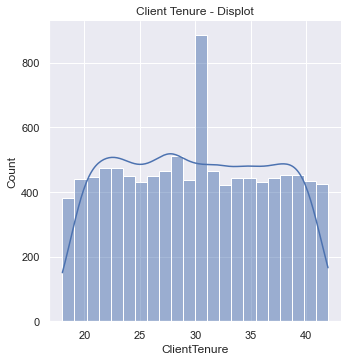

In [82]:
#To plot client tenure
sns.displot(data= data_mf, x='ClientTenure', kde=True)

title = "Client Tenure - Displot"
plt.title(title)
plt.show()

There is a even distribution of tenures with a spik at 30 years of tenure.<br> We would expect a more normal distribution.

#### B) Client Age

In [87]:
# same logic as ClientTenure here for ClientAge
data_mf['ClientAge'].replace(988, None, inplace=True)

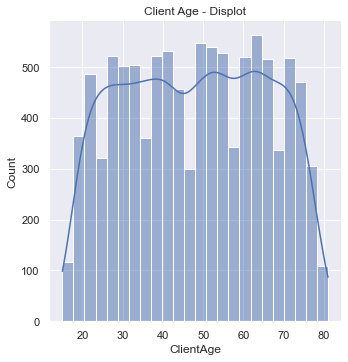

In [85]:
#To plot client tenure
sns.displot(data= data_mf, x='ClientAge', kde=True)

title = "Client Age - Displot"
plt.title(title)
plt.show()

#### C) Month Salary

In [88]:
#To filter clients with a montly salary higher or equal to 3k - not losing the missings
data_mf = data_mf[(data_mf['MonthSal']<30000) | (data_mf['MonthSal'].isna())]

In [ ]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

In [53]:
def plot_numfeat (df, feat):
    f, axs = plt.subplots(2,2,figsize=(15,5))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feat])
    title = 'Boxplot'
    plt.title(title, fontsize = 15)
    plt.subplot(1, 2, 2)
    sns.distplot(x=df[feat], kde = True)
    title = 'Histogram'
    plt.title(title, fontsize = 15)
    plt.xlabel(feat)
    plt.show()

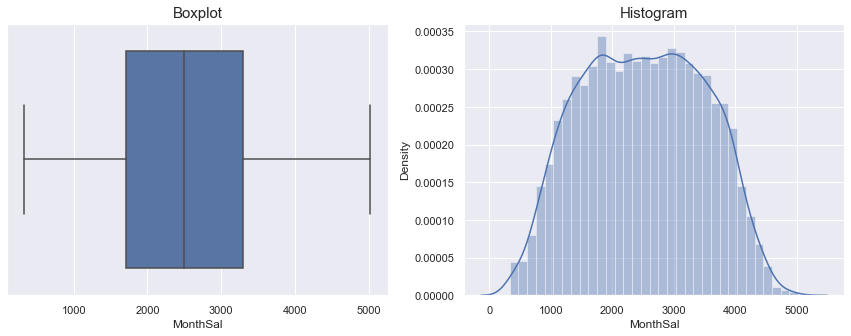

In [93]:
plot_numfeat(data_mf, 'MonthSal')

#### D) Motor Premium

As we can see, there is a client with 12k motor premium.<br> 
Let's remove clients with a motor premium higher than 2000

In [89]:
#To check how many clients have a premium higher than 2k
data_mf[data_mf['PremMotor']>=2000] 

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
5129,b'1 - Basic',3763.0,1.0,0.0,466.21,0.90,4003.44,612.9,137.36,121.69,31.34,20.0,73.0,0,0
5212,b'2 - High School',4135.0,3.0,0.0,130.14,0.99,8744.61,101.7,1767.00,155.14,130.58,35.0,73.0,0,0
5294,b'3 - BSc/MSc',3564.0,3.0,1.0,11875.89,0.09,11604.42,48.9,1045.52,103.13,296.47,27.0,53.0,0,0
6702,b'3 - BSc/MSc',2947.0,4.0,0.0,4328.50,0.03,4273.49,83.9,105.13,3.00,3.89,21.0,65.0,0,0
7086,b'3 - BSc/MSc',2460.0,3.0,1.0,5596.84,0.01,5645.50,0.0,49.01,1.89,1.89,24.0,53.0,1,1
7905,b'3 - BSc/MSc',2354.0,4.0,1.0,-46.89,1.01,3106.62,30.0,59.01,12.89,9.00,42.0,57.0,0,0


In [90]:
# Filter clients with a motor premium higher or equal to 2k
data_mf = data_mf[data_mf['PremMotor']<2000]

In [91]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

We kept 99.89% of the original data


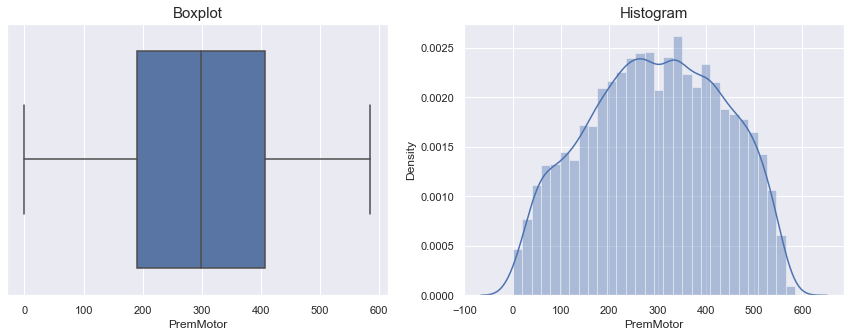

In [94]:
plot_numfeat(data_mf, 'PremMotor')

#### E) Household Premium

In [96]:
#To check how many clients have a premium higher than 1500
len(data_mf[data_mf['PremHousehold']>=1500])

14

In [92]:
# Filter clients with a home premium higher or equal to 1500k
data_mf = data_mf[data_mf['PremHousehold']<1300]

In [93]:
print('we kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

we kept 99.58% of the original data


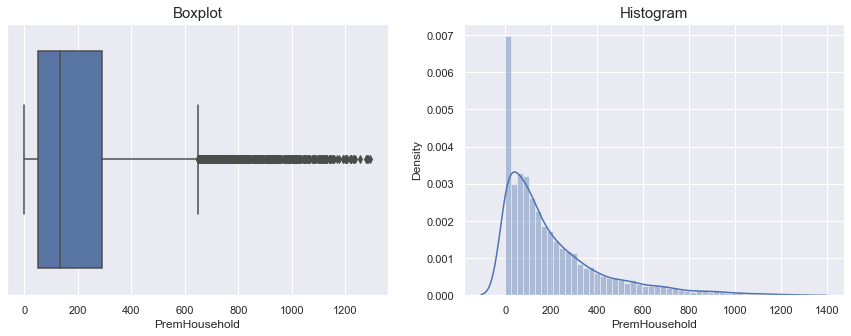

In [102]:
plot_numfeat(data_mf, 'PremHousehold')

Household premium is very skewed to the right. Lets see if we can transform the variable to present a more bell shape distribution

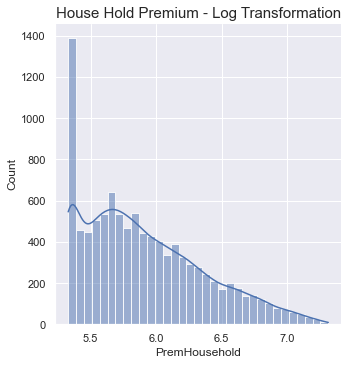

In [103]:
# Home Premims log transformation
sns.displot(data=data_mf, x=np.log(data_mf['PremHousehold']+data_mf['PremHousehold'].mean()), kde=True)

title = 'House Hold Premium - Log Transformation'
plt.title(title, fontsize = 15)
plt.show()

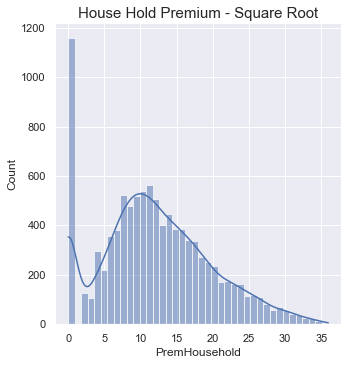

In [104]:
# Home Premims square root
sns.displot(data=data_mf, x=np.sqrt(data_mf['PremHousehold']), kde=True)

title = 'House Hold Premium - Square Root'
plt.title(title, fontsize = 15)
plt.show()

#### F) Health Premium

In [105]:
#To check how many clients have a premium higher than 5k
len(data_mf[data_mf['PremHealth']>5000])

2

In [94]:
# Filter clients with a home premium higher or equal to 5k
data_mf = data_mf[data_mf['PremHealth']<=400]

In [95]:
print('we kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

we kept 99.49% of the original data


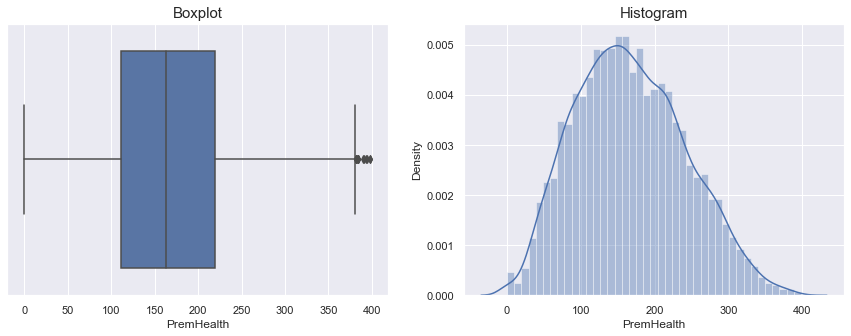

In [111]:
plot_numfeat(data_mf, 'PremHealth')

#### G) Life Premium

In [112]:
#To check how many clients have a premium higher than 250
len(data_mf[data_mf['PremLife']>=250])

50

In [96]:
data_mf = data_mf[data_mf['PremLife']<250]

In [97]:
print('we kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

we kept 99.01% of the original data


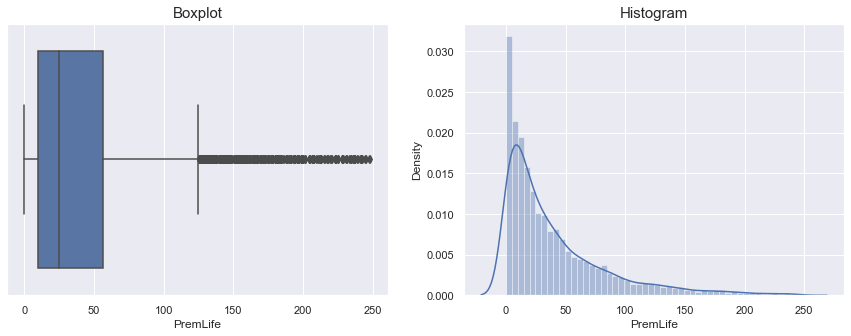

In [116]:
plot_numfeat(data_mf, 'PremLife')

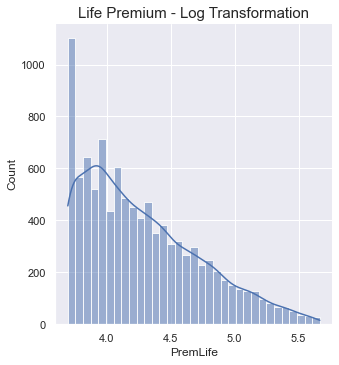

In [117]:
# Life Premims log transformation
sns.displot(data=data_mf, x=np.log(data_mf['PremLife']+data_mf['PremLife'].mean()), kde=True)

title = 'Life Premium - Log Transformation'
plt.title(title, fontsize = 15)
plt.show()

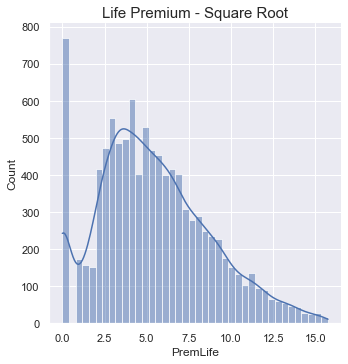

In [119]:
#Life Premims square root
sns.displot(data=data_mf, x=np.sqrt(data_mf['PremLife']), kde=True)

title = 'Life Premium - Square Root'
plt.title(title, fontsize = 15)
plt.show()

#### H) Work Premium

In [120]:
#To check how many clients have a premium higher than 300
len(data_mf[data_mf['PremWork']>=300])

16

In [98]:
data_mf = data_mf[data_mf['PremWork']<300]

In [99]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

We kept 98.85% of the original data


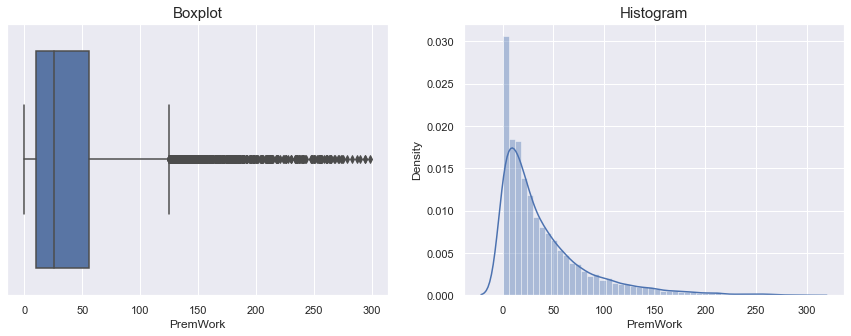

In [124]:
plot_numfeat(data_mf, 'PremWork')

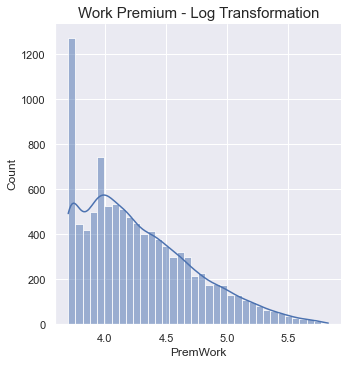

In [125]:
#Work Premims log transformation
sns.displot(data=data_mf, x=np.log(data_mf['PremWork']+data_mf['PremWork'].mean()), kde=True)

title = 'Work Premium - Log Transformation'
plt.title(title, fontsize = 15)
plt.show()

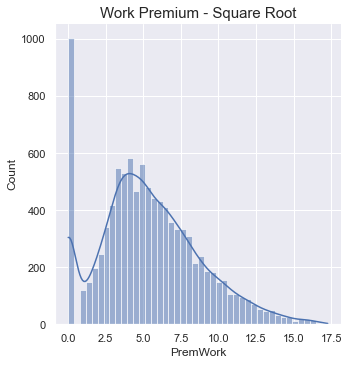

In [126]:
#Work Premims square root
sns.displot(data=data_mf, x=np.sqrt(data_mf['PremWork']), kde=True)

title = 'Work Premium - Square Root'
plt.title(title, fontsize = 15)
plt.show()

#### I) Costumer Value

In [127]:
#To check how many clients have a premium lower than -2000
len(data_mf[data_mf['CustMonVal']<-2000])

14

In [100]:
data_mf = data_mf[data_mf['CustMonVal']>=-2000]

In [101]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

We kept 98.72% of the original data


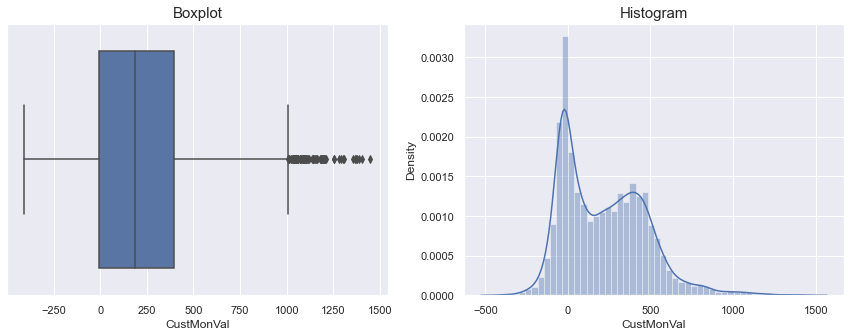

In [130]:
plot_numfeat(data_mf, 'CustMonVal')

In [132]:
len(data_mf[data_mf['CustMonVal']>1250])

13

In [102]:
data_mf = data_mf[data_mf['CustMonVal']<=1250]

In [103]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

We kept 98.59% of the original data


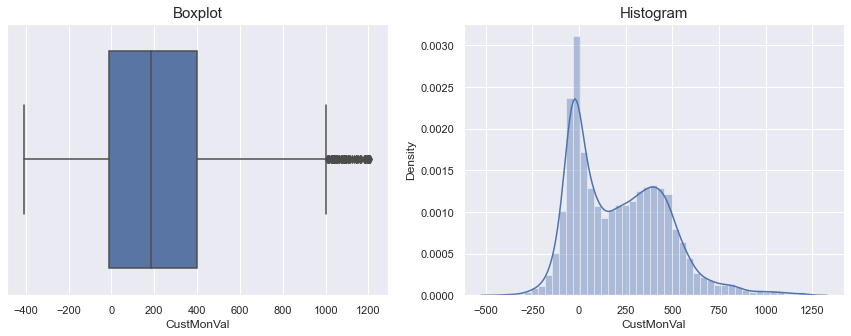

In [134]:
plot_numfeat(data_mf, 'CustMonVal')

<hr>
<a class="anchor" id="missings">
    
## 3.3) Missing values
    
</a>

In [137]:
#To check missing data
data_mf.isna().sum()

EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor          0
PremHousehold      0
PremHealth         0
PremLife           0
PremWork           0
ClientTenure      30
ClientAge         17
TotalCancelled     0
Cancelled          0
dtype: int64

To fill nan values, we decided to create a predictive model in order to estimate MonthSal.<br>
Possible explanatory variables = EducDeg, AgeClient, GeoLivArea, Children


In [138]:
#To check how many clients have MonthSal and ClientAge missing
print(len(data_mf[(data_mf.MonthSal.isna()) & (data_mf.ClientAge.isna())]))

0


In [139]:
#To check how many clients have MonthSal and EducDeg missing
print(len(data_mf[(data_mf.MonthSal.isna()) & (data_mf.EducDeg.isna())]))

1


In [140]:
#To check how many clients have MonthSal and GeoLivArea missing
print(len(data_mf[(data_mf.MonthSal.isna()) & (data_mf.GeoLivArea.isna())]))

0


In [141]:
#To check how many clients have MonthSal and GeoLivArea missing
print(len(data_mf[(data_mf.MonthSal.isna()) & (data_mf.Children.isna())]))

0


Only 1  client has EducDeg and MonthSal missing, the rest of the clients are ok.

In [104]:
#There is 1 client with GeoLivArea missing. 
#We will not use this variable in clusters but it will be used to impute the other variables so we will drop it
data_mf.dropna(subset=['GeoLivArea'], inplace=True)

In [105]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_mf)/(len(dataset)))*100))

We kept 98.58% of the original data


In [144]:
#Monthly Salary
#Age is correlated with montly salary but maybe eductation level is too
#What is the average salary by education level
data_mf.groupby('EducDeg')['MonthSal'].median()

EducDeg
b'1 - Basic'          1850.5
b'2 - High School'    2512.0
b'3 - BSc/MSc'        2615.0
b'4 - PhD'            2645.0
Name: MonthSal, dtype: float64

**- Higher degree greater the average salary**

In [145]:
#Indeed we see that higher the education, higher the monthly salary
#Also works for living area?
#What is the average salary by Geographic Living Area
data_mf.groupby('GeoLivArea')['MonthSal'].median()

GeoLivArea
1.0    2491.0
2.0    2573.0
3.0    2481.0
4.0    2535.0
Name: MonthSal, dtype: float64

**- Living area 2 and 4 have higher average salaries compared with 1 and 3. But is it really different?**

In [146]:
#Also it will work for Children?
#What is the average salary by children
data_mf.groupby('Children')['MonthSal'].median()

Children
0.0    3509.0
1.0    2204.0
Name: MonthSal, dtype: float64

**- People without children have a higher average salary.**

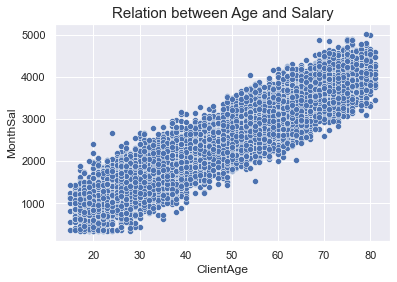

In [147]:
#To check the relation between age and salary
sns.scatterplot(data=data_mf, x='ClientAge',y='MonthSal')

title = 'Relation between Age and Salary'
plt.title(title, fontsize = 15)

plt.show()

As we can see, Client Age and Month Salary are directly proportional and they have a positive correlation.<br> If one variable increases, the other will increase in the same proportion.

In [106]:
#Encoding level of education
data_mf['EducDeg'] = np.where(data_mf['EducDeg']==b'1 - Basic', 'Basic', data_mf['EducDeg'])
data_mf['EducDeg'] = np.where(data_mf['EducDeg']==b'2 - High School', 'HighSchool', data_mf['EducDeg'])
data_mf['EducDeg'] = np.where(data_mf['EducDeg']==b'3 - BSc/MSc', 'BscMsc', data_mf['EducDeg'])
data_mf['EducDeg'] = np.where(data_mf['EducDeg']==b'4 - PhD', 'PhD', data_mf['EducDeg'])

educ_dummys = pd.get_dummies(data_mf['EducDeg'], prefix='Educ')

In [107]:
educ_dummys.head()

,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD
CustID,,,,
1,0,0,1,0
2,0,0,1,0
3,1,0,0,0
4,0,1,0,0
5,0,1,0,0


In [108]:
#To change the type of GeoLivArea to int
data_mf['GeoLivArea'] = data_mf['GeoLivArea'].astype('int32')
liv_dummys = pd.get_dummies(data_mf['GeoLivArea'], prefix='LivArea')

In [109]:
liv_dummys.head()

,LivArea_1,LivArea_2,LivArea_3,LivArea_4
CustID,,,,
1,1,0,0,0
2,0,0,0,1
3,0,0,1,0
4,0,0,0,1
5,0,0,0,1


In [110]:
#To merge the data
data_miss = pd.concat([data_mf,educ_dummys,liv_dummys], axis=1)
data_miss.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
CustID,,,,,,,,,,,,,,,,,,,,,
1,HighSchool,2177.0,1,1.0,380.97,0.39,375.85,79.45,146.36,47.01,...,0,0,0,0,1,0,1,0,0,0
2,HighSchool,677.0,4,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,...,0,0,0,0,1,0,0,0,0,1
3,Basic,2277.0,3,0.0,504.67,0.28,206.15,224.50,124.58,86.35,...,0,0,1,0,0,0,0,0,1,0
4,BscMsc,1099.0,4,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,...,0,0,0,1,0,0,0,0,0,1
5,BscMsc,1763.0,4,1.0,35.23,0.90,338.62,47.80,182.59,18.78,...,0,0,0,1,0,0,0,0,0,1


In [111]:
#To train the models I need to take the missings
dt_impute = data_miss.dropna()

In [112]:
#To predict MonthSal 
features = ['ClientAge','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','LivArea_1','LivArea_2','LivArea_3','LivArea_4','Children']
X_train = dt_impute[features]
y_train = dt_impute.MonthSal

In [113]:
DecisionTree = DecisionTreeRegressor().fit(X_train,y_train)

In [114]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(dt_impute.MonthSal, DecisionTree.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(dt_impute.MonthSal, DecisionTree.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 338.36


By predicting the missing values with a decision tree using client age, level of education and living area we can explain around 88% of the variability of MonthSal.

Lets predict the values:

In [115]:
#To reset index for row iteration since we already drop some columns
data_miss.reset_index(inplace=True)

In [116]:
for i in range(len(data_miss)):
    if pd.isnull(data_miss.iloc[i]['MonthSal']) == True:
        data_miss['MonthSal'].iloc[i] = DecisionTree.predict(pd.DataFrame(data_miss.iloc[i][features]).T)[0]

In [117]:
#To get the CustID of the person who has MonthSal = None
data_mf.loc[(data_mf['MonthSal'].isna())].head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,
22,HighSchool,NaN,3,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34,39.0,58.0,0,0
144,BscMsc,NaN,4,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01,20.0,26.0,0,0
489,BscMsc,NaN,3,0.0,-52.56,1.09,0.00,0.00,278.83,0.00,27.56,39.0,69.0,0,0
540,HighSchool,NaN,2,1.0,85.13,0.79,156.25,0.00,237.71,12.89,110.13,37.0,24.0,0,0
831,HighSchool,NaN,4,0.0,475.43,0.00,274.83,0.00,180.59,25.45,19.56,28.0,74.0,0,0


In [118]:
data_miss.loc[data_miss['CustID']==144]

,CustID,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
138,144,BscMsc,1383.575758,4,1.0,-42.45,1.02,146.36,353.95,220.04,...,0,0,0,1,0,0,0,0,0,1


In [121]:
#We will fill categorical and discrete variables with mode
data_miss['ClientAge'].fillna(data_miss['ClientAge'].median(),inplace=True)
data_miss['ClientTenure'].fillna(data_miss['ClientTenure'].median(),inplace=True)
data_miss['EducDeg'].fillna(data_miss['EducDeg'].mode()[0],inplace=True)
data_miss['Children'].fillna(data_miss['Children'].mode()[0],inplace=True)

In [122]:
#To check Nan Values
data_miss.isna().sum()

CustID             0
EducDeg            0
MonthSal           0
GeoLivArea         0
Children           0
CustMonVal         0
ClaimsRate         0
PremMotor          0
PremHousehold      0
PremHealth         0
PremLife           0
PremWork           0
ClientTenure       0
ClientAge          0
TotalCancelled     0
Cancelled          0
Educ_Basic         0
Educ_BscMsc        0
Educ_HighSchool    0
Educ_PhD           0
LivArea_1          0
LivArea_2          0
LivArea_3          0
LivArea_4          0
dtype: int64

**As we can see, all None values are removed**

In [123]:
data_miss.set_index('CustID', inplace=True)

<hr>
<a class="anchor" id="preprocess">
    
# 4) Data preprocessing
    
</a>

In [124]:
data_prep = data_miss.copy()

Firstly, we will take a look again to the data summary:

In [125]:
data_prep[metric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10150.0,2511.990012,977.766319,333.00,1729.00,2517.500,3295.0000,5021.00
CustMonVal,10150.0,215.150600,249.440490,-406.07,-9.22,186.265,397.7500,1209.11
ClaimsRate,10150.0,0.680925,0.319485,0.00,0.39,0.720,0.9800,4.33
PremMotor,10150.0,298.681054,137.268821,0.00,194.26,300.445,408.4925,585.22
PremHousehold,10150.0,203.948764,218.747066,0.00,48.90,132.250,284.5000,1286.90
PremHealth,10150.0,167.641750,74.494898,0.00,111.80,162.920,219.8200,398.41
PremLife,10150.0,40.234087,43.776797,0.00,9.78,24.670,56.0100,248.27
PremWork,10150.0,40.403003,44.723703,0.00,9.89,25.450,55.7900,298.50
ClientTenure,10150.0,29.972315,6.598229,18.00,24.00,30.000,36.0000,42.00
ClientAge,10150.0,48.168276,17.233950,15.00,33.00,48.000,63.0000,81.00


There are clients with 15 years old, that strange for clients in a insurance company. Lets check if there are clients that are younger that their oldest policy:

In [126]:
#To get the number of clients where the client tenure is higher than their age
len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])

1901

In [127]:
#To check the percentage of clients where client tenure is higher than their age
percentage_aux = round(len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])/len(data_prep),3)*100

print('\033[1mPercentage of clients where client tenure is higher than their age:\033[0m', percentage_aux)

Percentage of clients where client tenure is higher than their age: 18.7


**Almost 2k clients have a policy which is older than them. It represent 20% of the data.**

- Age is very correlated with monthly salary. In montly salary there is just have 36 missings. So MonthSal it will be kept and ClientAge will be dropped
- Age is, in general, more correlated with other variables (premium variables) than salary. That is obvious since age is used by insurance companies in their tariffs. Younger customers generaly have higher premiums, not because they bring more value but because they represent a higher risk (more claims)
- Motor premiums have a great contribution for client TotalPremiums and very correlated with age. Younger drivers have more claims on average
- So, in our opinion, when using age, may not compute meaningfull clusters

<hr>
<a class="anchor" id="feateng">
    
## 4.1) Feature engineering
    
</a>

In [68]:
#To check data types
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10150 entries, 1 to 10296
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EducDeg          10150 non-null  object 
 1   MonthSal         10150 non-null  float64
 2   GeoLivArea       10150 non-null  int32  
 3   Children         10150 non-null  float64
 4   CustMonVal       10150 non-null  float64
 5   ClaimsRate       10150 non-null  float64
 6   PremMotor        10150 non-null  float64
 7   PremHousehold    10150 non-null  float64
 8   PremHealth       10150 non-null  float64
 9   PremLife         10150 non-null  float64
 10  PremWork         10150 non-null  float64
 11  ClientTenure     10150 non-null  float64
 12  ClientAge        10150 non-null  float64
 13  TotalCancelled   10150 non-null  int32  
 14  Cancelled        10150 non-null  int32  
 15  Educ_Basic       10150 non-null  uint8  
 16  Educ_BscMsc      10150 non-null  uint8  
 17  Educ_HighSch

In [128]:
#To change the datatype to int64
data_prep['Children'] = data_prep['Children'].astype('int64')
data_prep['ClientAge'] = data_prep['ClientAge'].astype('int64')
data_prep['ClientTenure'] = data_prep['ClientTenure'].astype('int64')
data_prep['GeoLivArea'] = data_prep['GeoLivArea'].astype('int64')

In [129]:
#To create new variables
data_prep['TotalPremiums'] = data_prep['PremMotor']+data_prep['PremHousehold']+data_prep['PremHealth']+data_prep['PremLife']+data_prep['PremWork']
data_prep['YearSal'] = data_prep['MonthSal']*14
data_prep['EffortRate'] = data_prep['TotalPremiums']/data_prep['YearSal']

In [130]:
#To normalize premium variables
data_prep['PremHousehold_Sqr'] = np.sqrt(data_prep['PremHousehold'])
data_prep['PremLife_Sqr'] = np.sqrt(data_prep['PremLife'])
data_prep['PremWork_Sqr'] = np.sqrt(data_prep['PremWork'])

#### A) Total Premiums

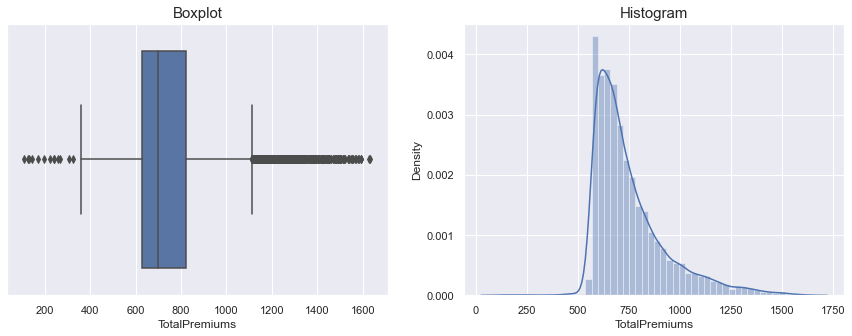

In [202]:
plot_numfeat(data_prep, 'TotalPremiums')

In [198]:
#There are customers with no premiums?
len(data_prep[data_prep['TotalPremiums']<100])

14

In [131]:
#To filter clients with a home premium higher or equal to 100
data_prep = data_prep.loc[data_prep['TotalPremiums']>=100]

In [132]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_prep)/(len(dataset)))*100))

We kept 98.45% of the original data


#### B) Year Salary

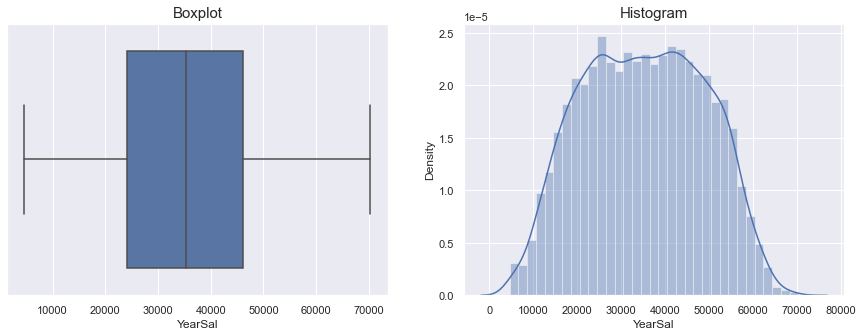

In [203]:
plot_numfeat(data_prep, 'YearSal')

#### C) Effort Rate

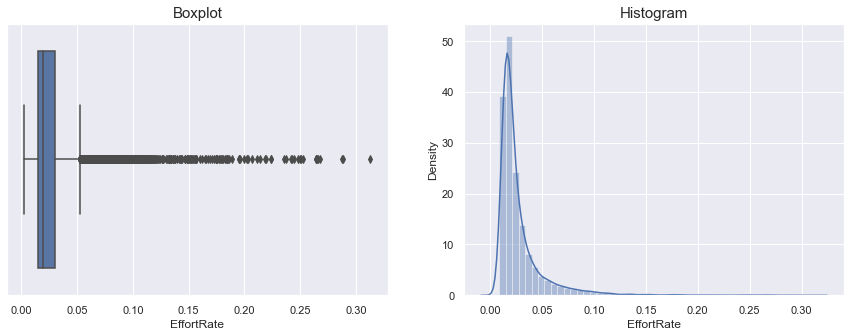

In [204]:
#Effort Rate
plot_numfeat(data_prep, 'EffortRate')

In [205]:
#There are customers with na Effort Rate higher than 0.2
len(data_prep[data_prep['EffortRate']>0.2])

27

In [133]:
#To filter clients with a effort rate lower or equal to 0.2 or with none value
data_prep = data_prep[(data_prep['EffortRate']<=0.2) | (data_prep['EffortRate'].isna())]

In [134]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(data_prep)/(len(dataset)))*100))

We kept 98.18% of the original data


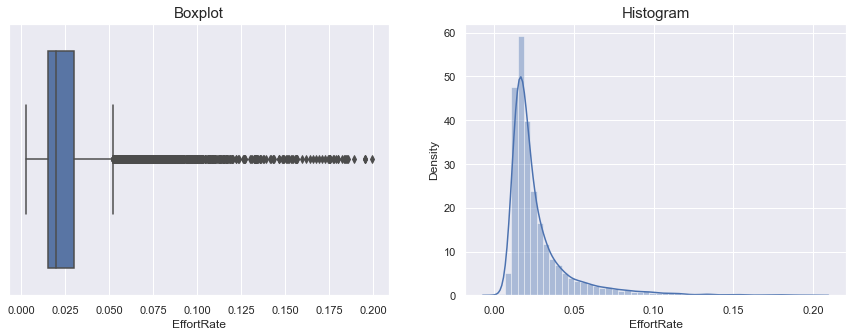

In [208]:
plot_numfeat(data_prep, 'EffortRate')

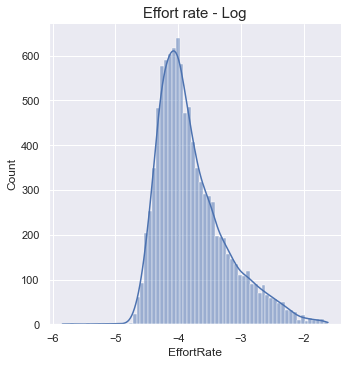

In [210]:
#Work Premims square root
sns.displot(data=data_prep, x=np.log(data_prep['EffortRate']), kde=True)

title = 'Effort rate - Log'
plt.title(title, fontsize = 15)
plt.show()

In [135]:
# transform effor rate
data_prep['EffortRate_log'] = np.log(data_prep['EffortRate'])

**We will create more new variables**

In [136]:
#To create new variables
#Client has specific LoB
data_prep['HasMotor'] = np.where(data_prep['PremMotor']>0,1,0)
data_prep['HasHome'] = np.where(data_prep['PremHousehold']>0,1,0)
data_prep['HasHealth'] = np.where(data_prep['PremHealth']>0,1,0)
data_prep['HasLife'] = np.where(data_prep['PremLife']>0,1,0)
data_prep['HasWork'] = np.where(data_prep['PremWork']>0,1,0)

#Total number of LoB
data_prep['NumberProducts'] = data_prep['HasMotor']+data_prep['HasHome']+data_prep['HasHealth']+data_prep['HasLife']+data_prep['HasWork']

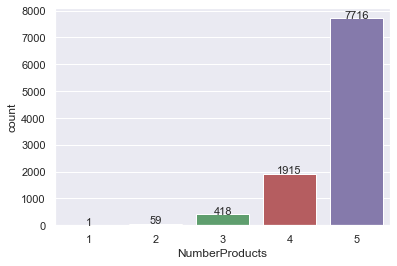

In [215]:
#Single Non-Metric variable bar plot
#Number Products
sns.set() 
ax = sns.countplot(x=data_prep['NumberProducts'], order = data_prep['NumberProducts'].value_counts().index.sort_values())

# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

In [137]:
#To aggregate number of products
data_prep['NumberProducts'] = np.where(data_prep['NumberProducts'] < 4, 3, data_prep['NumberProducts'])

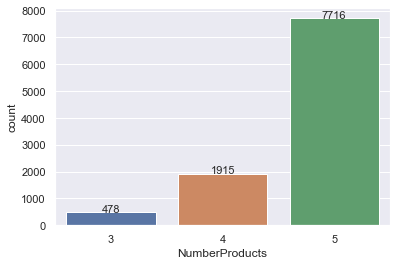

In [217]:
#Single Non-Metric variable bar plot
#Number Products
sns.set() 
ax = sns.countplot(x=data_prep['NumberProducts'], order = data_prep['NumberProducts'].value_counts().index.sort_values())

# show count (+ annotate)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

In [218]:
#To check data_prep
data_prep.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,...,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,EffortRate_log,HasMotor,HasHome,HasHealth,HasLife,HasWork,NumberProducts
CustID,,,,,,,,,,,,,,,,,,,,,
1,HighSchool,2177.0,1,1,380.97,0.39,375.85,79.45,146.36,47.01,...,8.913473,6.856384,4.109745,-3.824132,1,1,1,1,1,5
2,HighSchool,677.0,4,1,-131.13,1.12,77.46,416.20,116.69,194.48,...,20.400980,13.945609,10.301942,-2.342230,1,1,1,1,1,5
3,Basic,2277.0,3,0,504.67,0.28,206.15,224.50,124.58,86.35,...,14.983324,9.292470,9.950879,-3.762211,1,1,1,1,1,5
4,BscMsc,1099.0,4,1,-16.99,0.99,182.48,43.35,311.17,35.34,...,6.584072,5.944746,5.323533,-3.243151,1,1,1,1,1,5
5,BscMsc,1763.0,4,1,35.23,0.90,338.62,47.80,182.59,18.78,...,6.913754,4.333590,6.438167,-3.669317,1,1,1,1,1,5


In [138]:
#To add new variables to metric features
metric_features = metric_features+['TotalPremiums','YearSal','EffortRate','EffortRate_log','PremHousehold_Sqr','PremLife_Sqr','PremWork_Sqr', 'NumberProducts']

In [139]:
#To check metric_features
metric_features

['MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'ClientTenure',
 'ClientAge',
 'TotalCancelled',
 'TotalPremiums',
 'YearSal',
 'EffortRate',
 'EffortRate_log',
 'PremHousehold_Sqr',
 'PremLife_Sqr',
 'PremWork_Sqr',
 'NumberProducts']

In [140]:
#To check data_prep shape
data_prep.shape

(10109, 36)

<hr>
<a class="anchor" id="stand">
    
## 4.2) Standardization
    
</a>

In [141]:
#To create a new copy
df_train = data_prep.copy()

In [142]:
#To apply Standard Scaler
df_train_scaled = df_train.copy()
scaler = StandardScaler()
scaler.fit(df_train_scaled[metric_features])
df_train_scaled[metric_features] = scaler.transform(df_train[metric_features])

In [143]:
df_train_scaled.head()

,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,...,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,EffortRate_log,HasMotor,HasHome,HasHealth,HasLife,HasWork,NumberProducts
CustID,,,,,,,,,,,,,,,,,,,,,
1,HighSchool,-0.350540,1,1,0.669135,-0.920890,0.557605,-0.568844,-0.290377,0.158129,...,-0.412593,0.439539,-0.378479,-0.076209,1,1,1,1,1,0.52033
2,HighSchool,-1.892429,4,1,-1.393767,1.385295,-1.627859,0.987545,-0.689623,3.540095,...,1.102206,2.587428,1.463373,2.619042,1,1,1,1,1,0.52033
3,Basic,-0.247747,3,0,1.167438,-1.268398,-0.685309,0.101547,-0.583454,1.060323,...,0.387807,1.177623,1.358950,0.036411,1,1,1,1,1,0.52033
4,BscMsc,-1.458645,4,1,-0.933975,0.974605,-0.858673,-0.735691,1.927342,-0.109503,...,-0.719760,0.163331,-0.017441,0.980466,1,1,1,1,1,0.52033
5,BscMsc,-0.776102,4,1,-0.723616,0.690280,0.284926,-0.715124,0.197141,-0.489277,...,-0.676286,-0.324816,0.314104,0.205365,1,1,1,1,1,0.52033


<hr>
<a class="anchor" id="clust">
    
# 5) Clustering
    
</a>

In [144]:
#drop MonthSal, we will work with YearSal
df_train_scaled.drop('MonthSal', axis=1, inplace=True)

In [145]:
#To remove MonthSal from the list
metric_features = metric_features[1:]

In [146]:
metric_features

['CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'ClientTenure',
 'ClientAge',
 'TotalCancelled',
 'TotalPremiums',
 'YearSal',
 'EffortRate',
 'EffortRate_log',
 'PremHousehold_Sqr',
 'PremLife_Sqr',
 'PremWork_Sqr',
 'NumberProducts']

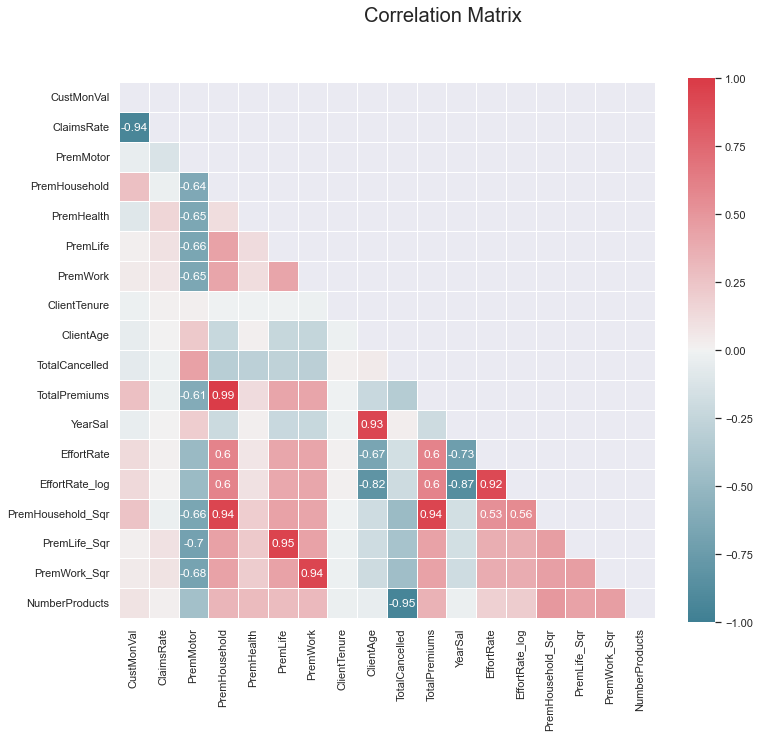

In [228]:
correlation(df_train_scaled, 0.5)

In [229]:
#To use perarson correlation
round(df_train_scaled[metric_features].corr(),2)

,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalCancelled,TotalPremiums,YearSal,EffortRate,EffortRate_log,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,NumberProducts
CustMonVal,1.00,-0.94,-0.04,0.27,-0.10,0.02,0.04,-0.02,-0.05,-0.07,0.27,-0.04,0.13,0.14,0.25,0.02,0.04,0.08
ClaimsRate,-0.94,1.00,-0.13,-0.03,0.15,0.09,0.07,0.01,-0.00,-0.02,-0.03,-0.00,0.01,0.00,-0.03,0.09,0.08,0.02
PremMotor,-0.04,-0.13,1.00,-0.64,-0.65,-0.66,-0.65,0.02,0.22,0.44,-0.61,0.20,-0.49,-0.48,-0.66,-0.70,-0.68,-0.43
PremHousehold,0.27,-0.03,-0.64,1.00,0.11,0.43,0.42,-0.01,-0.23,-0.32,0.99,-0.21,0.60,0.60,0.94,0.44,0.43,0.33
PremHealth,-0.10,0.15,-0.65,0.11,1.00,0.12,0.11,-0.01,0.02,-0.29,0.12,0.02,0.07,0.09,0.20,0.22,0.21,0.30
PremLife,0.02,0.09,-0.66,0.43,0.12,1.00,0.42,-0.01,-0.24,-0.28,0.42,-0.22,0.41,0.40,0.43,0.95,0.43,0.29
PremWork,0.04,0.07,-0.65,0.42,0.11,0.42,1.00,-0.02,-0.25,-0.30,0.42,-0.23,0.42,0.41,0.42,0.43,0.94,0.31
ClientTenure,-0.02,0.01,0.02,-0.01,-0.01,-0.01,-0.02,1.00,-0.02,0.02,-0.01,-0.02,0.01,0.01,-0.01,-0.02,-0.02,-0.03
ClientAge,-0.05,-0.00,0.22,-0.23,0.02,-0.24,-0.25,-0.02,1.00,0.04,-0.22,0.93,-0.67,-0.82,-0.19,-0.19,-0.20,-0.04
TotalCancelled,-0.07,-0.02,0.44,-0.32,-0.29,-0.28,-0.30,0.02,0.04,1.00,-0.33,0.03,-0.17,-0.20,-0.48,-0.41,-0.45,-0.95


In [231]:
df_train_scaled.columns

Index(['EducDeg', 'GeoLivArea', 'Children', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
       'ClientTenure', 'ClientAge', 'TotalCancelled', 'Cancelled',
       'Educ_Basic', 'Educ_BscMsc', 'Educ_HighSchool', 'Educ_PhD', 'LivArea_1',
       'LivArea_2', 'LivArea_3', 'LivArea_4', 'TotalPremiums', 'YearSal',
       'EffortRate', 'PremHousehold_Sqr', 'PremLife_Sqr', 'PremWork_Sqr',
       'EffortRate_log', 'HasMotor', 'HasHome', 'HasHealth', 'HasLife',
       'HasWork', 'NumberProducts'],
      dtype='object')

<hr>
<a class="anchor" id="stand">
    
## 5.1) DBSCAN
    
</a>

We already removed the outliers taking to account a 1 dimensional analysis. Lets now check if we still have outliers taking into account a multidimensional view.
For this lets only keep for the analysis the variables that we might use for clustering.
We will choose eps to remove a acceptable amount of observartions.

In [147]:
len(df_train_scaled)

10109

In [148]:
potential_features = ['CustMonVal','PremMotor', 'PremHousehold_Sqr', 'PremHealth', 'PremLife_Sqr', 'PremWork_Sqr','YearSal','EffortRate_log','NumberProducts']

In [149]:
#To perform DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=50, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_train_scaled[potential_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [150]:
## DBSCAN identified 132 observartions as outliers
np.unique(dbscan_labels, return_counts=True)

(array([-1,  0], dtype=int64), array([  100, 10009], dtype=int64))

In [151]:
df_train_scaled_concat = pd.concat([df_train_scaled,pd.Series(dbscan_labels, index=df_train_scaled.index, name="dbscan_labels")], axis=1)

In [152]:
# Detecting noise (potential outliers)
df_train_scaled_concat.loc[df_train_scaled_concat['dbscan_labels'] == -1].head(10)

,EducDeg,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,...,PremLife_Sqr,PremWork_Sqr,EffortRate_log,HasMotor,HasHome,HasHealth,HasLife,HasWork,NumberProducts,dbscan_labels
CustID,,,,,,,,,,,,,,,,,,,,,
45,BscMsc,1,1,-1.383897,1.606436,-1.376346,-0.936046,0.542563,4.233367,0.088870,...,2.903957,0.377281,1.001909,1,0,1,1,1,-1.311789,-1
139,HighSchool,2,1,-0.262937,0.026857,-0.772394,0.476374,-2.259830,-0.063636,-0.507247,...,0.213596,-0.350571,-0.686088,1,1,0,1,1,-1.311789,-1
156,BscMsc,3,0,1.508475,-0.794524,-1.461819,1.904277,2.070920,-0.919964,0.178647,...,-1.637804,0.464795,1.675930,1,1,1,0,1,-1.311789,-1
185,HighSchool,4,1,-1.116216,1.227337,-2.195190,0.237659,0.843174,-0.784887,0.063957,...,-0.902494,0.352300,-0.669974,0,1,1,1,1,-1.311789,-1
251,HighSchool,4,1,1.971369,-1.047257,-1.517996,2.017280,1.083906,-0.919964,2.223984,...,-1.637804,1.910478,1.453374,1,1,1,0,1,-1.311789,-1
306,BscMsc,3,0,-1.015830,1.069379,-0.348323,-0.936046,1.676114,-0.919964,-0.597024,...,-1.637804,-0.501161,-1.176929,1,0,1,0,1,-3.143909,-1
387,HighSchool,1,1,-0.096850,-0.478608,-1.172880,0.312070,-2.259830,-0.264990,-0.327694,...,-0.018635,-0.093878,0.253061,1,1,0,1,1,-1.311789,-1
489,BscMsc,3,0,-1.077262,1.290520,-2.195190,-0.936046,1.492168,-0.919964,-0.285274,...,-1.637804,-0.039384,-2.405208,0,0,1,0,1,-3.143909,-1
517,BscMsc,4,1,0.046840,-0.194284,-2.195190,0.471290,0.962800,0.295728,0.487927,...,0.568127,0.741379,0.017789,0,1,1,1,1,-1.311789,-1


In [153]:
df_train_filtered = df_train_scaled_concat.loc[df_train_scaled_concat['dbscan_labels'] > -1]

In [154]:
df_train_filtered.shape

(10009, 36)

In [155]:
print('We kept \033[1m{:.2f}\033[0m% of the original data'.format((len(df_train_filtered)/(len(dataset)))*100))

We kept 97.21% of the original data


<hr>
<a class="anchor" id="prodseg">
    
## 5.2) Product segmentation
    
</a>

In [156]:
product_features = ['PremMotor','PremHousehold_Sqr','PremHealth','PremLife_Sqr','PremWork_Sqr']

In [157]:
df_product = df_train_filtered[product_features]

In [158]:
df_product.head()

,PremMotor,PremHousehold_Sqr,PremHealth,PremLife_Sqr,PremWork_Sqr
CustID,,,,,
1,0.557605,-0.412593,-0.290377,0.439539,-0.378479
2,-1.627859,1.102206,-0.689623,2.587428,1.463373
3,-0.685309,0.387807,-0.583454,1.177623,1.358950
4,-0.858673,-0.719760,1.927342,0.163331,-0.017441
5,0.284926,-0.676286,0.197141,-0.324816,0.314104


In [253]:
kmeans_kwargs = {'init':"random", 'n_init':20, 'max_iter':50, 'random_state':42}

In [254]:
# A list holds the SSE values for each k
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_product)
    sse.append(kmeans.inertia_)

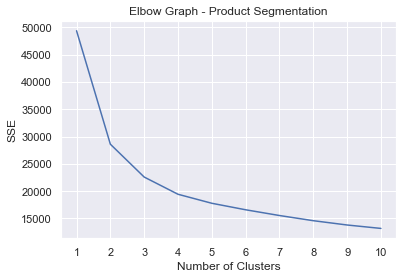

In [255]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph - Product Segmentation')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

It looks like its 3 clusters is the best choice

In [159]:
kmeans_product = KMeans(init="random", n_clusters=3, n_init=20, max_iter=50,random_state=42).fit(df_product)
cluster_product = pd.Series(kmeans_product.labels_, name='ClusterID_Product', index=df_product.index)

In [160]:
# The lowest SSE value
kmeans_product.inertia_

22584.991991529678

In [105]:
# Final locations of the centroid
kmeans_product.cluster_centers_

array([[ 1.06381997e+00, -7.07771855e-01, -8.33121984e-01,
        -7.33505039e-01, -7.24716541e-01],
       [-1.14476933e+00,  1.13186440e+00,  3.12304966e-02,
         1.13355789e+00,  1.11301102e+00],
       [-2.95898135e-01, -8.79358947e-04,  7.52346083e-01,
         2.06616930e-02,  3.68608101e-02]])

In [106]:
# The number of iterations required to converge
kmeans_product.n_iter_

11

In [161]:
# from scipy import stats
np.unique(kmeans_product.labels_, return_counts=True)

(array([0, 1, 2]), array([3695, 2271, 4043], dtype=int64))

In [162]:
## adding the cluster to the dataframe
df_product = pd.concat([df_product, cluster_product], axis=1)

In [163]:
df_product.groupby('ClusterID_Product')[product_features].agg('mean')

,PremMotor,PremHousehold_Sqr,PremHealth,PremLife_Sqr,PremWork_Sqr
ClusterID_Product,,,,,
0,1.063820,-0.707772,-0.833122,-0.733505,-0.724717
1,-1.146500,1.132725,0.030806,1.136229,1.113743
2,-0.296186,0.000318,0.751514,0.020813,0.038047


In [164]:
product_centroids = df_product.groupby('ClusterID_Product', as_index=False)[product_features].agg('mean')

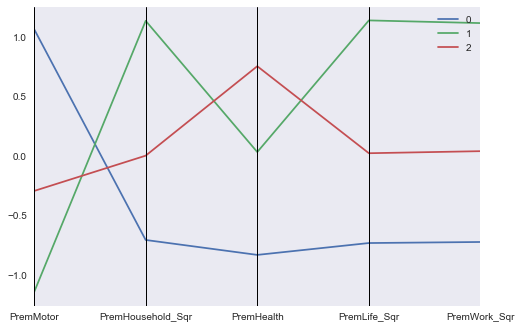

In [112]:
pd.plotting.parallel_coordinates(product_centroids, 'ClusterID_Product', color=sns.color_palette())
plt.show()

- Cluster 0: High motor premiums
- Cluster 1: High household, life and workerscomp premiums
- Cluster 2: High health premiums

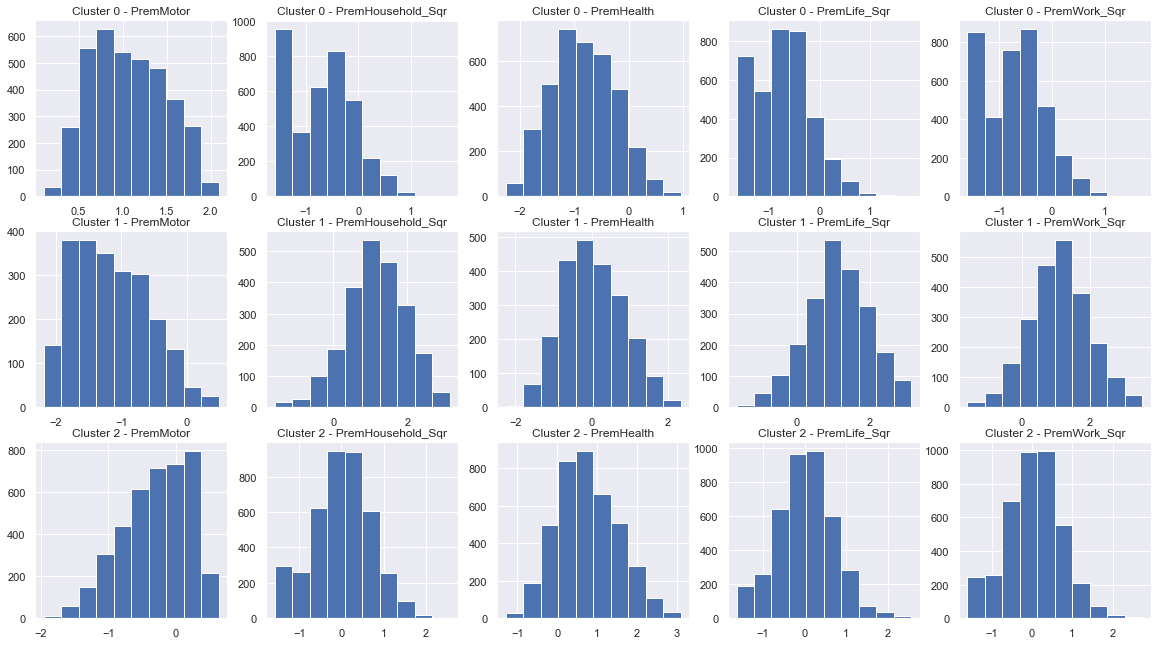

In [268]:
## plot variable distribution by cluster
clusters = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2]
features = product_features+product_features+product_features

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, 5, figsize=(20, 11))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat, k in zip(axes.flatten(), features, clusters): # Notice the zip() function and flatten() method
    ax.hist(df_product.loc[df_product['ClusterID_Product']== k,feat])
    ax.set_title('Cluster ' + str(k) + ' - ' + feat, y=1)

In [481]:
def draw_umap(data, label, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(10,10))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=label, cmap='Dark2')
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=label, cmap='Dark2')
    if n_components == 3:
        fig = plt.figure(figsize=(6,6))
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        sc = ax.scatter(u[:,0], u[:,1], u[:,2], s=40, c=label, marker='o', alpha=0.8, cmap='Dark2')
        ax.set_xlabel('component1')
        ax.set_ylabel('component2')
        ax.set_zlabel('component3')
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
        
    plt.title(title, fontsize=18)
    plt.show()

<Figure size 720x720 with 0 Axes>

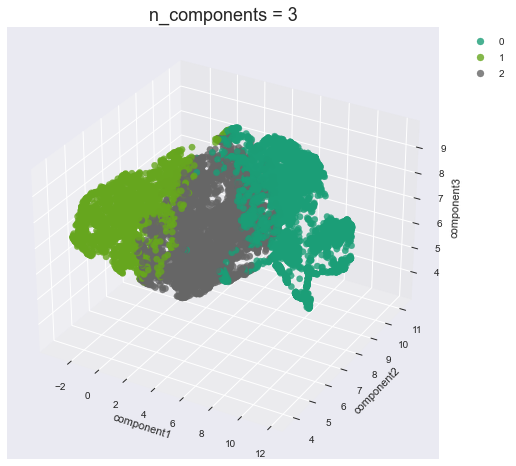

In [482]:
draw_umap(data=df_product.drop('ClusterID_Product',axis=1), label=df_product['ClusterID_Product'], n_components=3, title='n_components = 3')

<hr>
<a class="anchor" id="valueseg">
    
## 5.3) Value segmentation
    
</a>

In [693]:
value_features = ['TotalPremiums','CustMonVal','EffortRate_log','NumberProducts']

In [694]:
df_value = df_train_filtered[value_features]

In [695]:
df_value.head()

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts
CustID,,,,
1,-0.482535,0.669135,-0.076209,0.52033
2,0.910387,-1.393767,2.619042,0.52033
3,-0.056598,1.167438,0.036411,0.52033
4,-0.850802,-0.933975,0.980466,0.52033
5,-0.688692,-0.723616,0.205365,0.52033


In [272]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

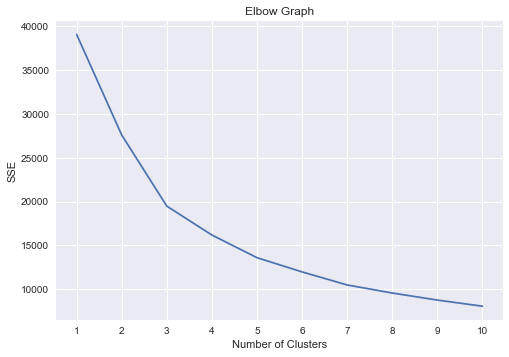

In [273]:
# Plot Elbow graphic
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [172]:
kmeans_value = KMeans(init="random", n_clusters=3, n_init=20, max_iter=50,random_state=42)

In [173]:
kmeans_value.fit(df_value)

KMeans(init='random', max_iter=50, n_clusters=3, n_init=20, random_state=42)

In [174]:
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2]), array([1883, 2245, 5881], dtype=int64))

In [175]:
cluster_value = pd.Series(kmeans_value.labels_,name='ClusterID_Value', index=df_value.index)

In [176]:
## adding the cluster to the dataframe
df_value = pd.concat([df_value, cluster_value], axis=1)

In [177]:
df_value.head()

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts,ClusterID_Value
CustID,,,,,
1,-0.482535,0.669135,-0.076209,0.52033,2
2,0.910387,-1.393767,2.619042,0.52033,0
3,-0.056598,1.167438,0.036411,0.52033,2
4,-0.850802,-0.933975,0.980466,0.52033,2
5,-0.688692,-0.723616,0.205365,0.52033,2


In [178]:
df_value.groupby('ClusterID_Value')[value_features].agg('mean')

,TotalPremiums,CustMonVal,EffortRate_log,NumberProducts
ClusterID_Value,,,,
0,1.513565,0.597704,1.415160,0.473627
1,-0.700371,-0.152905,-0.438409,-1.682294
2,-0.218769,-0.130511,-0.289260,0.520330


In [179]:
value_centroids = df_value.groupby('ClusterID_Value', as_index=False)[value_features].agg('mean')

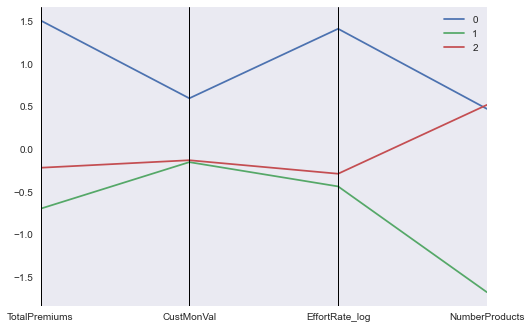

In [169]:
pd.plotting.parallel_coordinates(value_centroids, 'ClusterID_Value', color=sns.color_palette())
plt.show()

It seems that effor rate it should not be in the analysis since its bringing the same information of YearSal

In [696]:
#To try again taking out Effort Rate
df_value.drop(columns=['ClusterID_Value','EffortRate_log'], inplace=True)

In [286]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_value)
    sse.append(kmeans.inertia_)

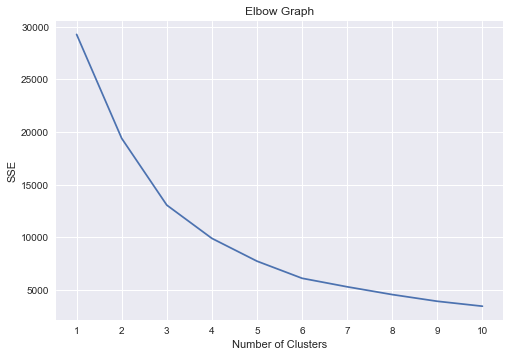

In [287]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [707]:
kmeans_value = KMeans(init="random", n_clusters=4, n_init=20, max_iter=50,random_state=42)

In [708]:
kmeans_value.fit(df_value)

KMeans(init='random', max_iter=50, n_clusters=4, n_init=20, random_state=42)

In [709]:
np.unique(kmeans_value.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([1525, 2719, 3507, 2258], dtype=int64))

In [710]:
cluster_value = pd.Series(kmeans_value.labels_,name='ClusterID_Value', index=df_value.index)

In [711]:
#To add the cluster to the dataframe
df_value = pd.concat([df_value.drop(columns=['ClusterID_Value']), cluster_value], axis=1)

In [712]:
# value_features.remove('EffortRate_log')
df_value.groupby('ClusterID_Value')[value_features].agg('mean')

,TotalPremiums,CustMonVal,NumberProducts
ClusterID_Value,,,
0,1.808611,0.897688,0.478281
1,-0.233296,0.638574,0.520330
2,-0.160637,-0.783028,0.520330
3,-0.695003,-0.152572,-1.680161


In [713]:
value_centroids = df_value.groupby('ClusterID_Value', as_index=False)[value_features].agg('mean')

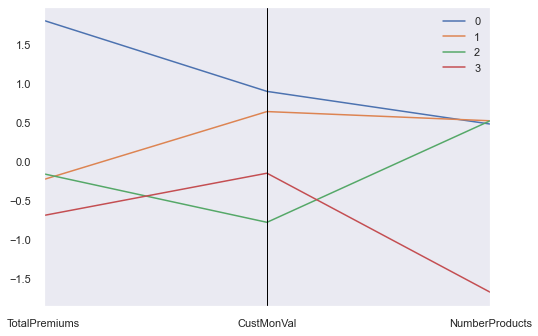

In [714]:
pd.plotting.parallel_coordinates(value_centroids, 'ClusterID_Value', color=sns.color_palette())
plt.show()

- Cluster 0: High total premiums, high value customers and high number of products
- Cluster 1: average total premiums, average value customers and high number of products
- Cluster 2: lower total premiums, average value customers and low number of products

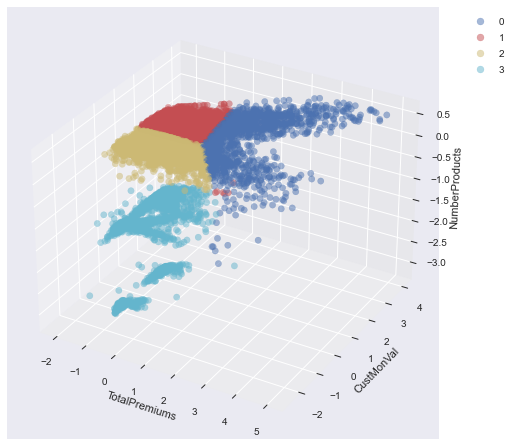

In [189]:
#3D plot

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette().as_hex())

# plot
sc = ax.scatter(df_value['TotalPremiums'], df_value['CustMonVal'], df_value['NumberProducts'], s=40, c=df_value['ClusterID_Value'], marker='o', alpha=.5, cmap=cmap)
ax.set_xlabel('TotalPremiums')
ax.set_ylabel('CustMonVal')
ax.set_zlabel('NumberProducts')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

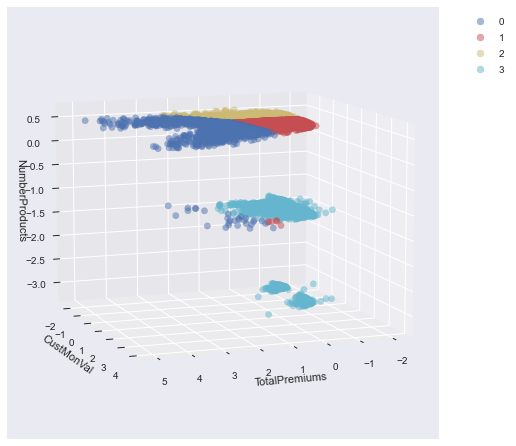

In [190]:
ax.view_init(10, 70)
fig

<hr>
<a class="anchor" id="demoseg">
    
## 5.4) Demographic segmentation
    
</a>

For the demographic segmentation we are going to use K-prototypes that allow us to used a mix of continuos and categorical variables.
To use the categorical variables we need to encode them to ordinal variables and tell pass a mask list to the algorithm that identifies each of the features are categorical.

<hr>
<a class="anchor" id="encod">
    
### 5.4.1) Encoding categorical features
    
</a>

In [191]:
demo_features = ['EducDeg','YearSal','Children']
df_demo = df_train_filtered[demo_features]

In [192]:
# kprototypes needs categorical variables to be integers and numeric variables floats
encoder = OrdinalEncoder(categories=[['Basic','HighSchool','BscMsc','PhD']]).fit(np.array(df_demo.EducDeg).reshape(-1,1))
df_demo.EducDeg = encoder.transform(np.array(df_demo.EducDeg).reshape(-1,1))

In [193]:
df_demo.EducDeg = df_demo.EducDeg.astype(int)
df_demo.head()

,EducDeg,YearSal,Children
CustID,,,
1,1,-0.350540,1
2,1,-1.892429,1
3,0,-0.247747,0
4,2,-1.458645,1
5,2,-0.776102,1


In [194]:
# Get the position of categorical columns
catColumnsPos = [0,2]

In [419]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 7):
    kprototype = KPrototypes(n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(df_demo, categorical = catColumnsPos)
    cost.append(kprototype.cost_)

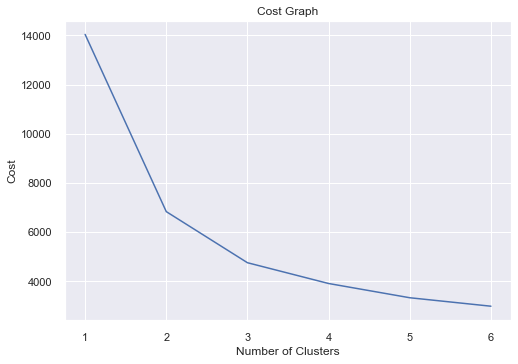

In [420]:
# plt.style.use("seaborn")
plt.plot(range(1, 7), cost)
plt.xticks(range(1, 7))
plt.title('Cost Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")
plt.show()

In [195]:
kprot_demo = KPrototypes(n_clusters = 3, init = 'Huang', random_state = 0).fit(df_demo, categorical = catColumnsPos)

In [196]:
np.unique(kprot_demo.labels_, return_counts=True)

(array([0, 1, 2], dtype=uint16), array([3163, 4019, 2827], dtype=int64))

In [197]:
cluster_demo = pd.Series(kprot_demo.labels_,name='ClusterID_Demo', index=df_demo.index)

In [198]:
## adding the cluster to the dataframe
df_demo = pd.concat([df_demo, cluster_demo], axis=1)

In [199]:
# value_features.remove('EffortRate_log')
df_demo.groupby('ClusterID_Demo').agg({'EducDeg':pd.Series.mode,'YearSal':'mean','Children':pd.Series.mode})

,EducDeg,YearSal,Children
ClusterID_Demo,,,
0,1,-1.145368,1
1,2,0.056798,1
2,2,1.214209,0


In [200]:
# Even though cluster 1 and 2 have Msc as more frequent maybe 2 has higher proportion of PhD?
df_demo.groupby('ClusterID_Demo').EducDeg.value_counts(normalize=True).to_frame()

EducDeg
ClusterID_Demo EducDeg          
0              1        0.434082
               2        0.318052
               0        0.188429
               3        0.059437
1              2        0.578004
               1        0.270465
               0        0.077382
               3        0.074148
2              2        0.500531
               1        0.340998
               0        0.086311
               3        0.072161

- Cluster 0: High education, average salary and children <br>
- Cluster 1: High Education, high salary and no children <br>
- Cluster 2: Low education, low salary with children<br>




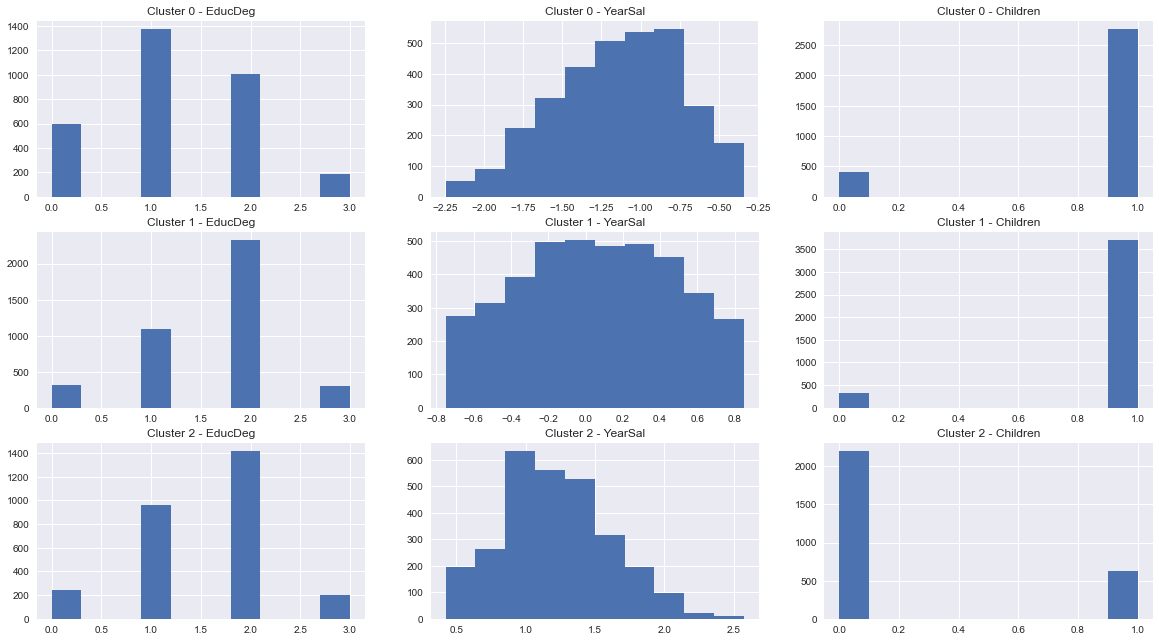

In [201]:
## plot variable distribution by cluster
clusters = [0,0,0,1,1,1,2,2,2]
features = demo_features+demo_features+demo_features

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, 3, figsize=(20, 11))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat, k in zip(axes.flatten(), features, clusters): # Notice the zip() function and flatten() method
    ax.hist(df_demo.loc[df_demo['ClusterID_Demo']== k,feat])
    ax.set_title('Cluster ' + str(k) + ' - ' + feat, y=1)

<hr>
<a class="anchor" id="merge">
    
## 5.5) Merging the clusters
    
</a>

In [202]:
df_train_scaled_cluster = pd.concat([df_train_filtered, cluster_product, cluster_value, cluster_demo], axis=1)

In [500]:
df_train_scaled_cluster.groupby(['ClusterID_Product','ClusterID_Value','ClusterID_Demo']).size().unstack()

ClusterID_Demo                         0       1      2
ClusterID_Product ClusterID_Value                      
0                 0                  NaN     3.0    NaN
                  1                182.0   580.0  206.0
                  2                159.0   631.0  218.0
                  3                265.0  1197.0  254.0
1                 0                608.0   154.0  227.0
                  1                235.0    97.0  136.0
                  2                455.0   144.0  204.0
                  3                  6.0     1.0    4.0
2                 0                 55.0    46.0   69.0
                  1                451.0   491.0  582.0
                  2                580.0   507.0  731.0
                  3                167.0   168.0  196.0

In [650]:
agg_features = product_features+value_features+demo_features

In [651]:
agg_features.remove('EducDeg')
agg_features.remove('Children')

In [652]:
print(agg_features)

['PremMotor', 'PremHousehold_Sqr', 'PremHealth', 'PremLife_Sqr', 'PremWork_Sqr', 'TotalPremiums', 'CustMonVal', 'NumberProducts', 'YearSal']


In [653]:
df_centroids = df_train_scaled_cluster.groupby(['ClusterID_Product','ClusterID_Value', 'ClusterID_Demo'])\
    [agg_features].mean()

In [654]:
df_centroids.head()

PremMotor  \
ClusterID_Product ClusterID_Value ClusterID_Demo              
0                 0               1                0.634924   
                  1               0                0.846415   
                                  1                1.008407   
                                  2                0.826579   
                  2               0                0.889785   

                                                  PremHousehold_Sqr  \
ClusterID_Product ClusterID_Value ClusterID_Demo                      
0                 0               1                        1.243088   
                  1               0                       -0.389786   
                                  1                       -0.386230   
                                  2                       -0.300462   
                  2               0                       -0.487209   

                                                  PremHealth  PremLife_Sqr  \
ClusterID_Product ClusterID_Value ClusterID_Demo                             
0                 0               1                -1.172657     -0.295337   
                  1               0                -0.608921     -0.508447   
                                  1                -0.880038     -0.516889   
                                  2                -0.607277     -0.429536   
                  2               0                -0.624924     -0.526785   

                                                  PremWork_Sqr  TotalPremiums  \
ClusterID_Product ClusterID_Value ClusterID_Demo                                
0                 0               1                  -0.616884       1.232015   
                  1               0                  -0.456272      -0.465513   
                                  1                  -0.465125      -0.450044   
                                  2                  -0.421948      -0.411676   
                  2               0                  -0.440236      -0.540920   

                                                  CustMonVal  NumberProducts  \
ClusterID_Product ClusterID_Value ClusterID_Demo                               
0                 0               1                 2.506813        0.520330   
                  1               0                 0.874549        0.520330   
                                  1                 0.972827        0.517171   
                                  2                 0.898833        0.502542   
                  2               0                -0.831151        0.520330   

                                                   YearSal  
ClusterID_Product ClusterID_Value ClusterID_Demo            
0                 0               1               0.241888  
                  1               0              -0.934927  
                                  1               0.079970  
                                  2               1.152223  
                  2               0              -0.877595

In [655]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None)

hclust_labels = hclust.fit_predict(df_centroids)

In [656]:
hclust_labels

array([19, 32, 30, 21, 33, 18, 20, 31, 16,  9, 25, 26, 24, 22, 27, 17, 23,
       29, 14, 10,  8, 28, 15, 12,  4, 13,  7, 11,  5,  6,  3,  2,  1,  0],
      dtype=int64)

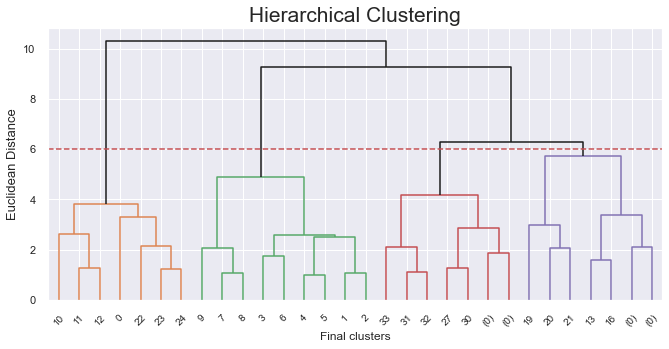

In [657]:

#create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together 
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
# track the number of observations in the current cluster being formed 
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 # leaf node
        else: 
            current_count += counts[child_idx - n_samples]
            counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 6
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed") 
plt.title('Hierarchical Clustering', fontsize=21)
plt.xlabel('Final clusters') 
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

#### With 4 final clusters

In [658]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

PremMotor  \
ClusterID_Product ClusterID_Value ClusterID_Demo              
0                 0               1                0.634924   
                  1               0                0.846415   
                                  1                1.008407   
                                  2                0.826579   
                  2               0                0.889785   
                                  1                1.013081   
                                  2                0.859991   
                  3               0                1.045843   
                                  1                1.288106   
                                  2                0.915324   
1                 0               0               -1.483240   
                                  1               -0.796720   
                                  2               -1.095670   
                  1               0               -1.148416   
                                  1               -0.598879   
                                  2               -0.805733   
                  2               0               -1.302426   
                                  1               -0.671263   
                                  2               -0.938424   
                  3               0               -1.252226   
                                  1               -0.425667   
                                  2               -1.071733   
2                 0               0               -0.751416   
                                  1               -0.333330   
                                  2               -0.696209   
                  1               0               -0.239598   
                                  1               -0.056581   
                                  2               -0.286618   
                  2               0               -0.494015   
                                  1               -0.120877   
                                  2               -0.415855   
                  3               0               -0.339459   
                                  1               -0.127220   
                                  2               -0.307464   

                                                  PremHousehold_Sqr  \
ClusterID_Product ClusterID_Value ClusterID_Demo                      
0                 0               1                        1.243088   
                  1               0                       -0.389786   
                                  1                       -0.386230   
                                  2                       -0.300462   
                  2               0                       -0.487209   
                                  1                       -0.443336   
                                  2                       -0.408110   
                  3               0                       -1.020134   
                                  1                       -1.074661   
                                  2                       -1.020523   
1                 0               0                        1.904443   
                                  1                        1.643916   
                                  2                        1.671743   
                  1               0                        0.558230   
                                  1                        0.523972   
                                  2                        0.561937   
                  2               0                        0.686996   
                                  1                        0.617228   
                                  2                        0.648840   
                  3               0                       -1.226073   
                                  1                       -1.587968   
                                  2                       -0.362075   
2                 0               0                        1.413763   
      

In [622]:
# df_centroids = df_centroids.reset_index()

# df_centroids["ClusterID_Product"] = df_centroids["ClusterID_Product"].astype(float).astype(int)
# df_centroids["ClusterID_Value"] = df_centroids["ClusterID_Value"].astype(float).astype(int)
# df_centroids["ClusterID_Demo"] = df_centroids["ClusterID_Demo"].astype(float).astype(int)

# df_centroids = df_centroids.set_index(["ClusterID_Product", "ClusterID_Value", 'ClusterID_Demo'])

In [623]:
# #To convert floats values to int values
# df_train_scaled_cluster['ClusterID_Product'] = df_train_scaled_cluster['ClusterID_Product'].astype('int32')
# df_train_scaled_cluster['ClusterID_Value'] = df_train_scaled_cluster['ClusterID_Value'].astype('int32') 
# df_train_scaled_cluster['ClusterID_Demo'] = df_train_scaled_cluster['ClusterID_Demo'].astype('int32')

In [659]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_train_scaled_cluster.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['ClusterID_Product'], row['ClusterID_Value'], row['ClusterID_Demo'])
    ], axis=1
)
df_train_scaled_cluster['merged_labels'] = df_train_scaled_cluster.apply(lambda row: cluster_mapper[(row['ClusterID_Product'], row['ClusterID_Value'], row['ClusterID_Demo'])], axis=1)

In [660]:
# Merged cluster centroids: averages for numeric variables
df_.groupby('merged_labels').agg('mean')[agg_features]

,PremMotor,PremHousehold_Sqr,PremHealth,PremLife_Sqr,PremWork_Sqr,TotalPremiums,CustMonVal,NumberProducts,YearSal
merged_labels,,,,,,,,,
0,-1.037815,0.609881,0.133592,1.240200,1.194575,0.440580,-0.306867,0.504610,-0.348598
1,-0.282153,-0.061973,0.756444,0.033693,0.046112,-0.191140,-0.170855,0.263937,0.159562
2,1.064168,-0.709357,-0.832846,-0.733861,-0.724804,-0.606166,-0.028821,-0.554030,0.104335
3,-1.184180,1.751797,0.003308,0.811709,0.835841,2.069326,1.012220,0.474606,-0.445995


In [661]:
# profiling for categorical variables
df_.groupby('merged_labels').agg({'EducDeg':pd.Series.mode,'Children':pd.Series.mode})

,EducDeg,Children
merged_labels,,
0,HighSchool,1
1,BscMsc,1
2,BscMsc,1
3,HighSchool,1


In [662]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

In [663]:
df_counts

,0
merged_labels,
0,1282
1,3873
2,3692
3,1162


<hr>
<a class="anchor" id="prof">
    
### 5.5.1) Profilling
    
</a>

In [664]:
# Merged cluster centroids
merged_centroids = df_train_scaled_cluster.groupby('merged_labels', as_index=False)[agg_features].agg('mean')

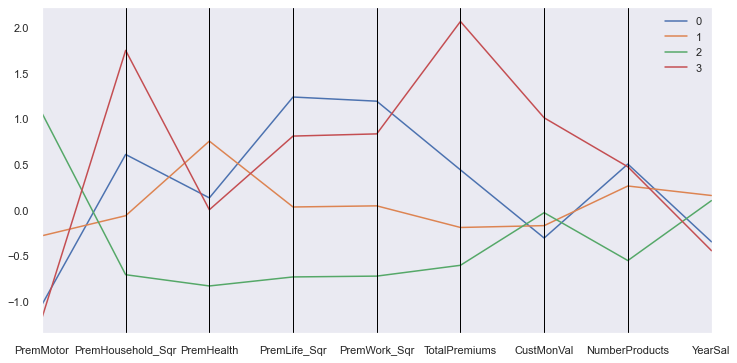

In [715]:
fig = plt.figure(figsize=(12,6))
pd.plotting.parallel_coordinates(merged_centroids, 'merged_labels', color=sns.color_palette())
plt.show()

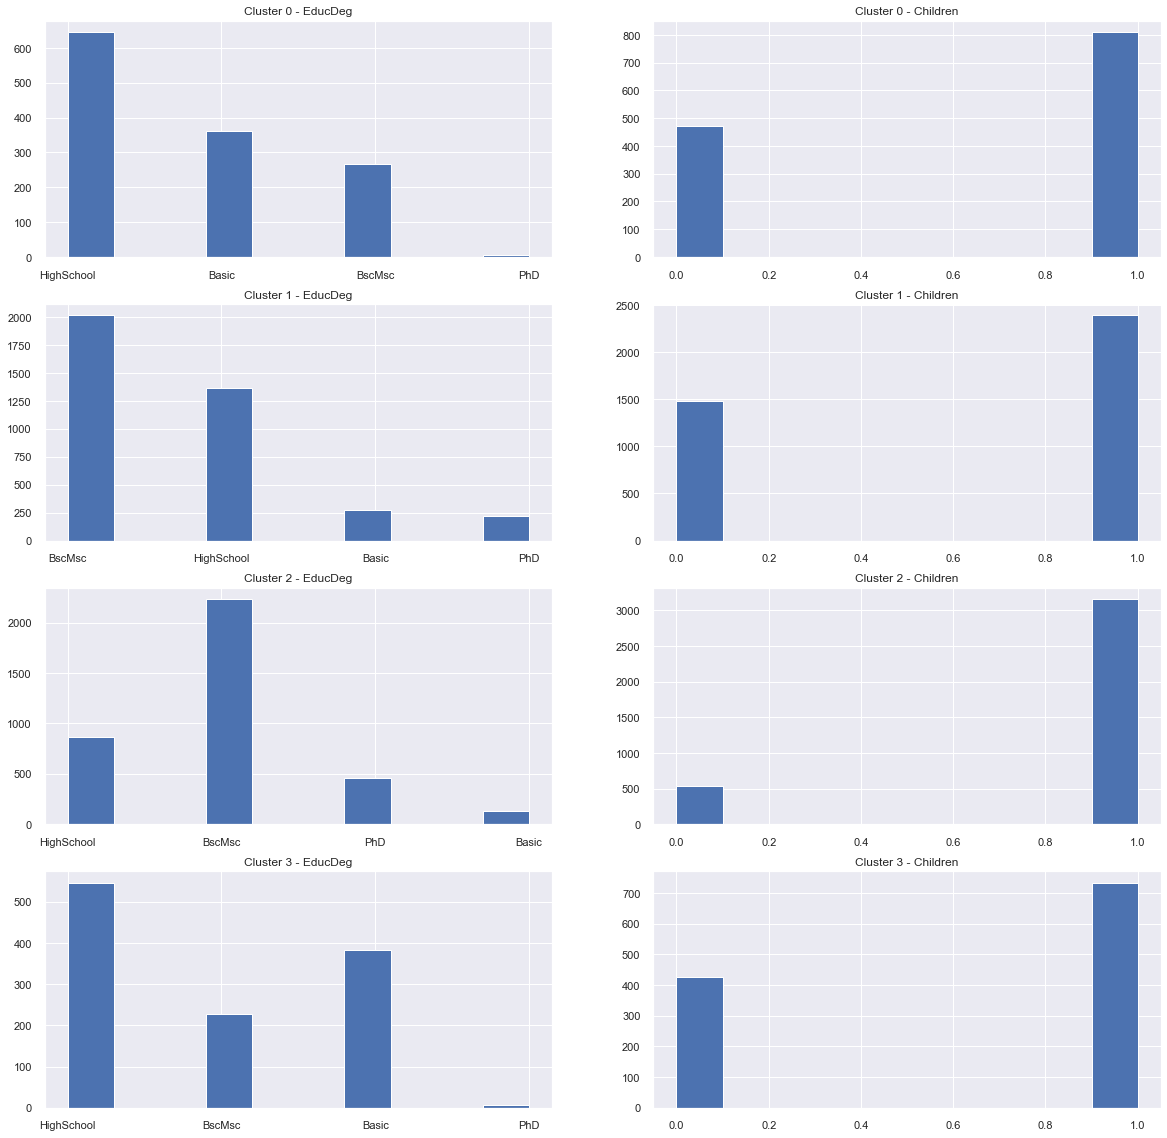

In [716]:
## plot variable distribution by cluster
clusters = [0,0,1,1,2,2,3,3]
features = ['EducDeg','Children']*4

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat, k in zip(axes.flatten(), features, clusters): # Notice the zip() function and flatten() method
    ax.hist(df_train_scaled_cluster.loc[df_train_scaled_cluster['merged_labels']== k,feat])
    ax.set_title('Cluster ' + str(k) + ' - ' + feat, y=1)

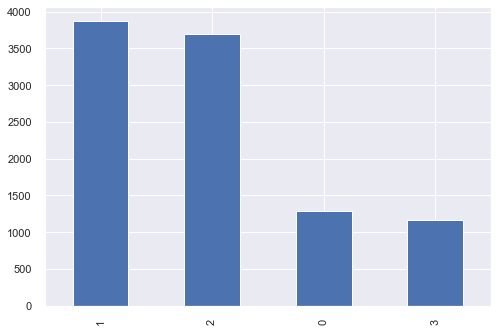

In [717]:
df_train_scaled_cluster['merged_labels'].value_counts(normalize=False).plot(kind='bar')
plt.show()

In [449]:
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(df_train_scaled_cluster[agg_features])
embedding.shape

(10009, 3)

In [488]:
agg_features.remove('NumberProducts')

<Figure size 720x720 with 0 Axes>

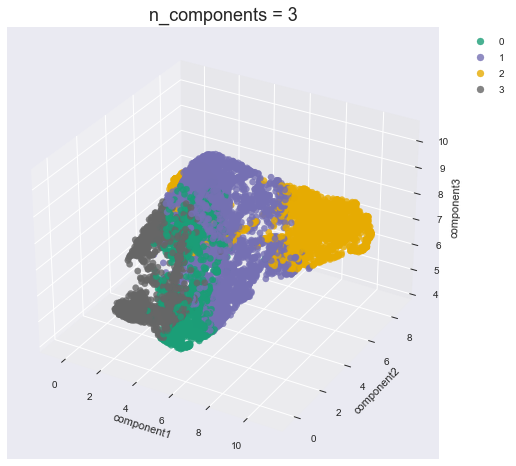

In [489]:
draw_umap(data=df_train_scaled_cluster[agg_features], label=df_train_scaled_cluster['merged_labels'], n_components=3, title='n_components = 3')

<hr>
<a class="anchor" id="reclass">
    
# 6) Reclassify the outliers
    
</a>

In [398]:
# create the dataframe with the filtered customers
df_train_filtered['Flag'] = 1
df_filt = df_train_filtered['Flag']
df_out = pd.concat([dataset, df_filt], axis=1)
df_out = df_out.loc[df_out.Flag != 1].drop('Flag', axis=1)

In [386]:
df_out.shape

(287, 13)

In [264]:
dt_features = ['Children','CustMonVal','PremMotor','PremHousehold','PremLife','PremWork','Educ_Basic','Educ_BscMsc',
              'Educ_HighSchool','Educ_PhD','TotalPremiums','YearSal','NumberProducts']

In [265]:
## Train decision tree to predict the label

# Preparing the data
X = df_train_scaled_cluster[dt_features]
y = df_train_scaled_cluster.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 94.46% of the customers correctly


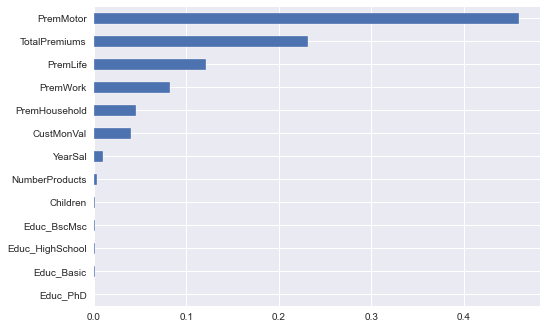

In [266]:
# Assessing feature importance for label prediction
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=True).plot(kind='barh')
plt.show()

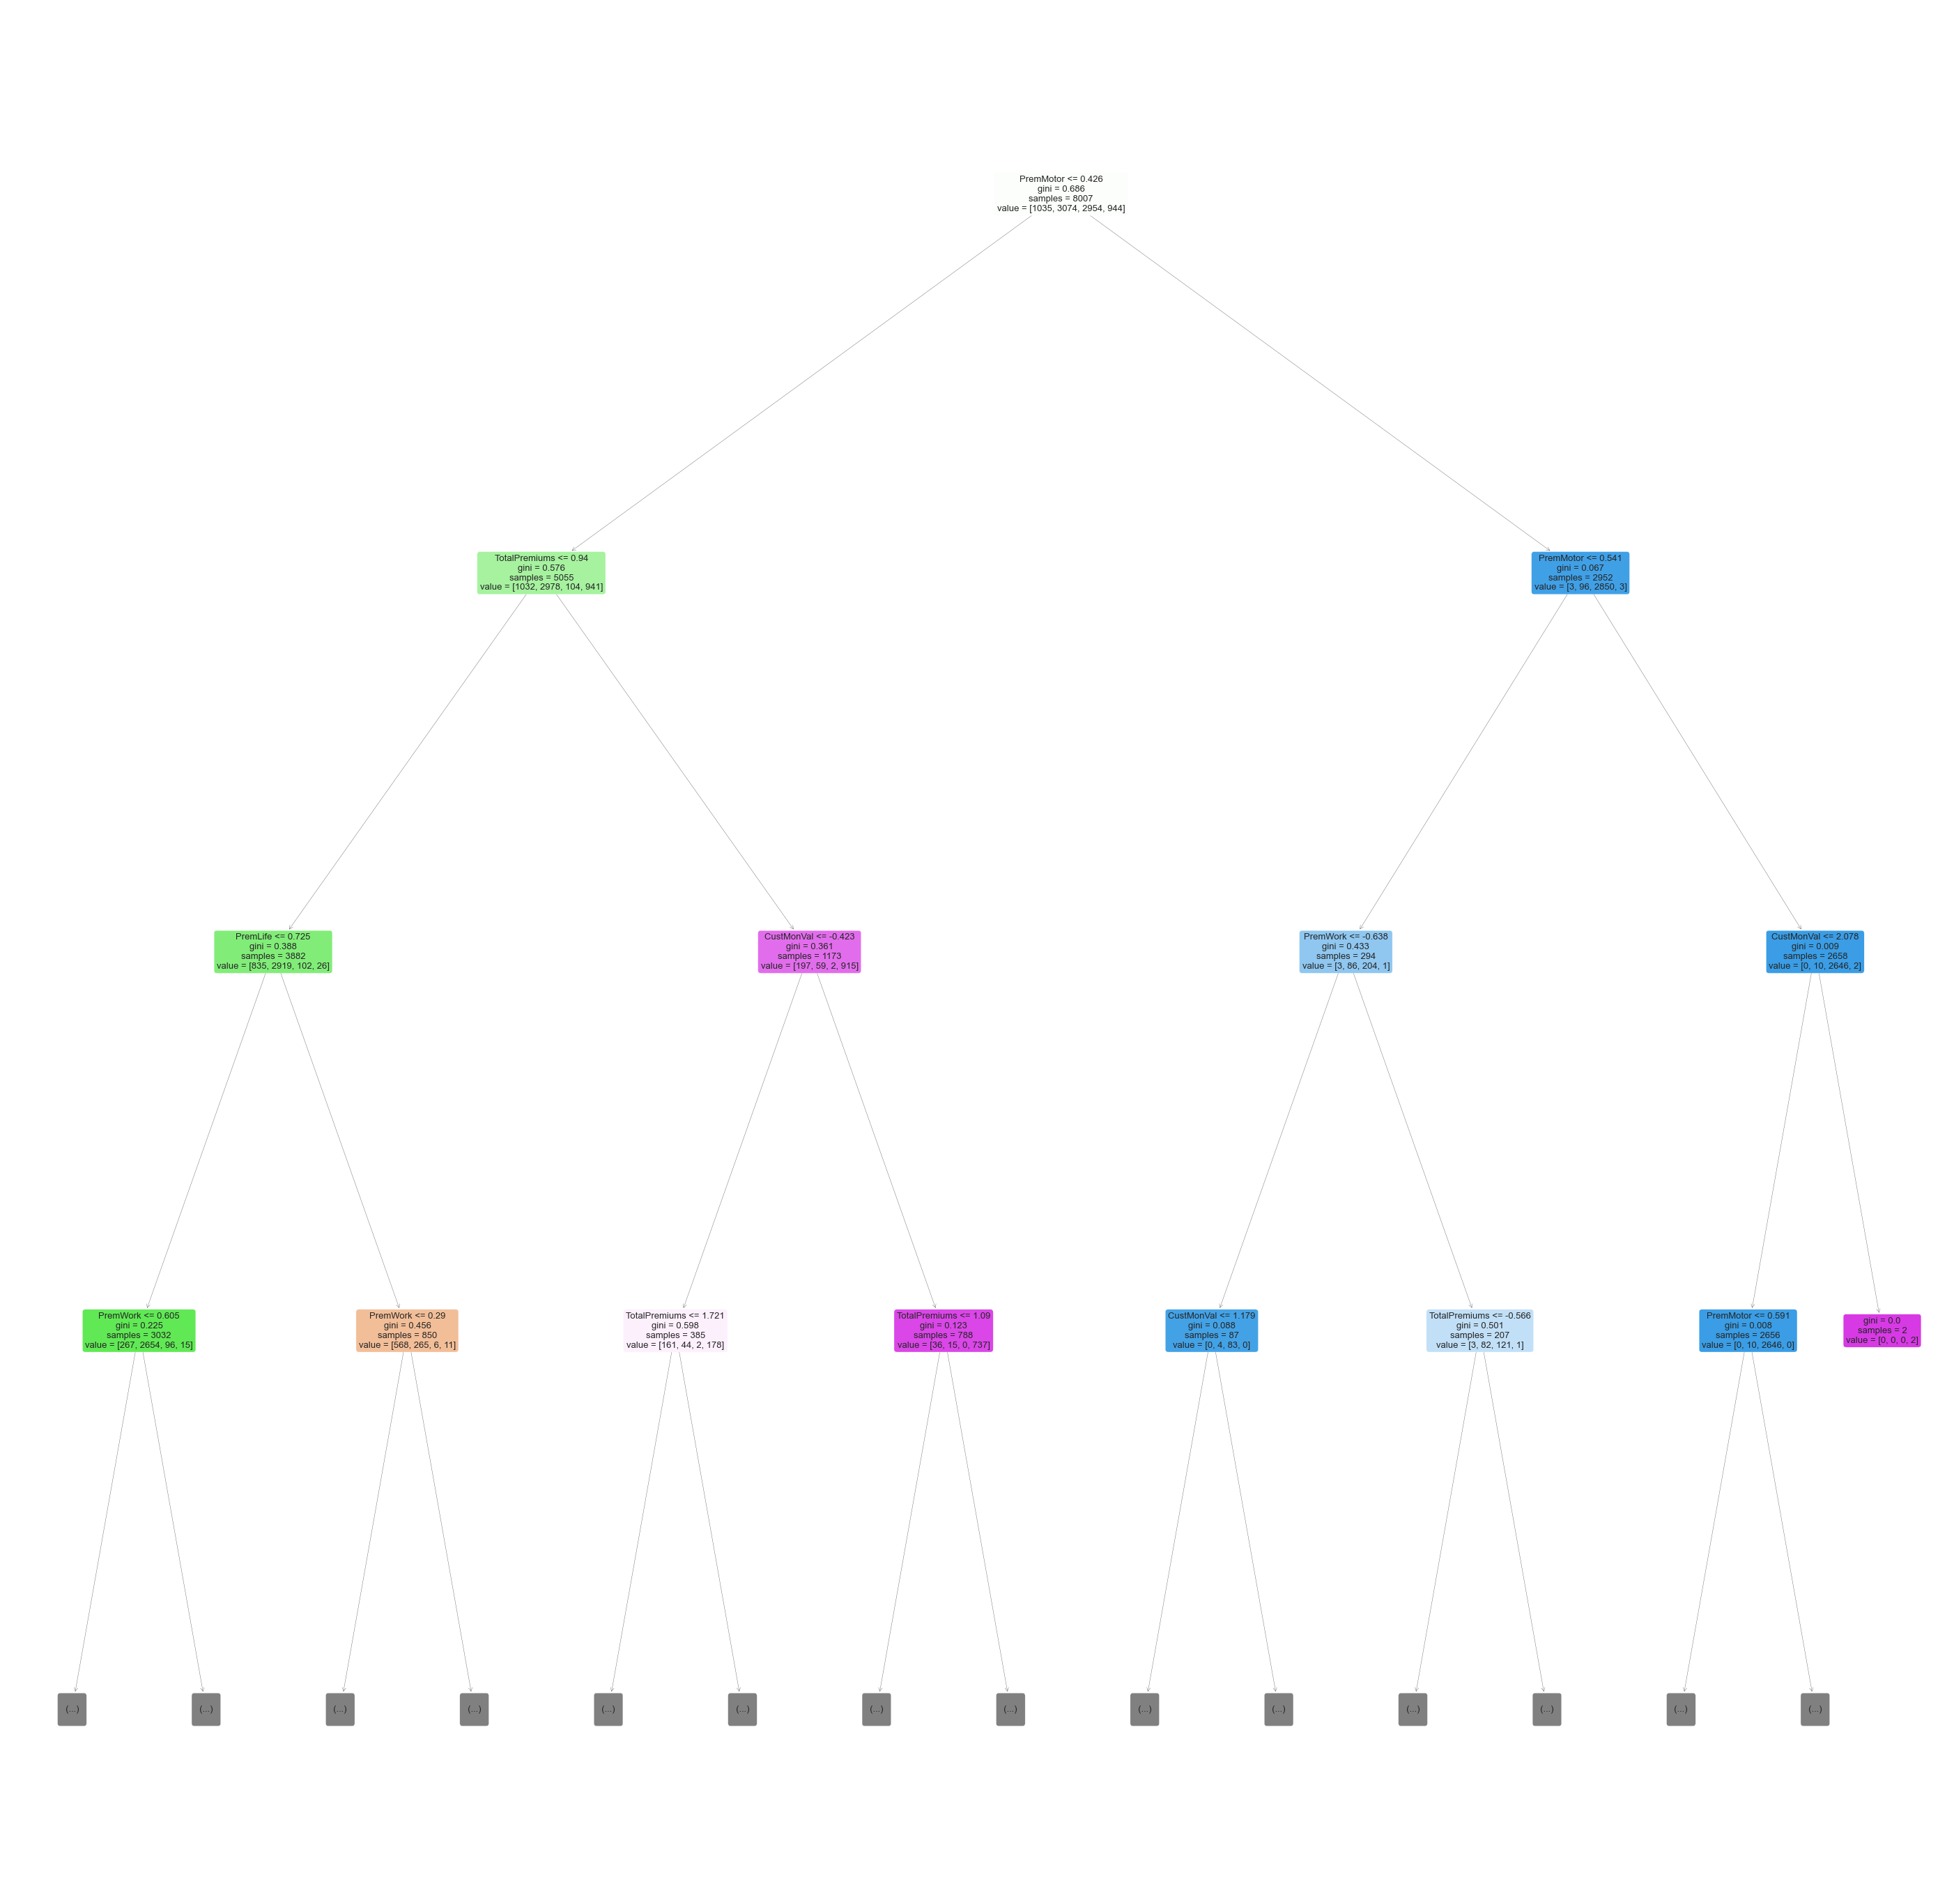

In [350]:
plt.figure(figsize=(50,50))
tree.plot_tree(dt, feature_names=X.columns.to_list(),filled=True,rounded=True, max_depth = 3)
plt.show()

In [275]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 14 to 10293
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   286 non-null    float64
 1   BirthYear      287 non-null    float64
 2   EducDeg        286 non-null    object 
 3   MonthSal       282 non-null    float64
 4   GeoLivArea     286 non-null    float64
 5   Children       286 non-null    float64
 6   CustMonVal     287 non-null    float64
 7   ClaimsRate     287 non-null    float64
 8   PremMotor      253 non-null    float64
 9   PremHousehold  287 non-null    float64
 10  PremHealth     255 non-null    float64
 11  PremLife       270 non-null    float64
 12  PremWork       268 non-null    float64
dtypes: float64(12), object(1)
memory usage: 31.4+ KB


In [276]:
df_out.isna().sum()

FirstPolYear      1
BirthYear         0
EducDeg           1
MonthSal          5
GeoLivArea        1
Children          1
CustMonVal        0
ClaimsRate        0
PremMotor        34
PremHousehold     0
PremHealth       32
PremLife         17
PremWork         19
dtype: int64

In [399]:
## dealing with the missing value

df_out.Children.fillna(df_out['Children'].mode()[0], inplace=True)
df_out.EducDeg.fillna(df_out['EducDeg'].mode()[0], inplace=True)
df_out.GeoLivArea.fillna(df_out['GeoLivArea'].mode()[0], inplace=True)
df_out.FirstPolYear.fillna(df_out['FirstPolYear'].mode()[0], inplace=True)

## create features to predict values of MonthSal

df_out['ClientAge'] = 2016-df_out['BirthYear']
df_out['ClientTenure'] = 2016-df_out['FirstPolYear']

#To create 5 aux new columns and mark the negative values 
df_out['MotorCancelled'] = np.where(df_out['PremMotor']<0,1,0)
df_out['HomeCancelled'] = np.where(df_out['PremHousehold']<0,1,0)
df_out['HealthCancelled'] = np.where(df_out['PremHealth']<0,1,0)
df_out['LifeCancelled'] = np.where(df_out['PremLife']<0,1,0)
df_out['WorkCancelled'] = np.where(df_out['PremWork']<0,1,0)

#To create a new column with the total number of negative values 
df_out['TotalCancelled'] = df_out['MotorCancelled']+df_out['HomeCancelled']+df_out['HealthCancelled']+df_out['LifeCancelled']+df_out['WorkCancelled']

#To create a binary column - 1 if policy was canceled and 0 otherwise 
df_out['Cancelled'] = np.where(df_out['TotalCancelled']>0,1,0)

#To replaces negative values for zeros
df_out['PremMotor'] = np.where(df_out['PremMotor']<0,0,df_out['PremMotor'])
df_out['PremHousehold'] = np.where(df_out['PremHousehold']<0,0,df_out['PremHousehold'])
df_out['PremHealth'] = np.where(df_out['PremHealth']<0,0,df_out['PremHealth'])
df_out['PremLife'] = np.where(df_out['PremLife']<0,0,df_out['PremLife'])
df_out['PremWork'] = np.where(df_out['PremWork']<0,0,df_out['PremWork'])

#We will consider that premiums missing is because client does not own the product
df_out['PremMotor'].fillna(0, inplace=True)
df_out['PremHousehold'].fillna(0, inplace=True)
df_out['PremHealth'].fillna(0, inplace=True)
df_out['PremLife'].fillna(0, inplace=True)
df_out['PremWork'].fillna(0, inplace=True)


#Encoding level of education

df_out['EducDeg'] = np.where(df_out['EducDeg']==b'1 - Basic', 'Basic', df_out['EducDeg'])
df_out['EducDeg'] = np.where(df_out['EducDeg']==b'2 - High School', 'HighSchool', df_out['EducDeg'])
df_out['EducDeg'] = np.where(df_out['EducDeg']==b'3 - BSc/MSc', 'BscMsc', df_out['EducDeg'])
df_out['EducDeg'] = np.where(df_out['EducDeg']==b'4 - PhD', 'PhD', df_out['EducDeg'])

educ_dummys_out = pd.get_dummies(df_out['EducDeg'], prefix='Educ')

#To change the type of GeoLivArea to int

df_out['GeoLivArea'].fillna(df_out['GeoLivArea'].mode()[0], inplace=True)

df_out['GeoLivArea'] = df_out['GeoLivArea'].astype('int32')
liv_dummys_out = pd.get_dummies(df_out['GeoLivArea'], prefix='LivArea')

In [400]:
#To merge the data
data_out = pd.concat([df_out,educ_dummys_out,liv_dummys_out], axis=1)
data_out.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
CustID,,,,,,,,,,,,,,,,,,,,,
14,1983.0,2000.0,Basic,1043.0,3,1.0,-75.12,1.06,44.34,342.85,...,0,0,1,0,0,0,0,0,1,0
45,1985.0,1990.0,BscMsc,1065.0,1,1.0,-128.68,1.19,111.80,0.00,...,1,1,0,1,0,0,1,0,0,0
52,1982.0,1966.0,BscMsc,3234.0,4,1.0,-14714.08,25.36,557.44,20.00,...,1,1,0,1,0,0,0,0,0,1
106,1986.0,1988.0,BscMsc,2019.0,4,1.0,-2.65,0.97,89.24,82.25,...,0,0,0,1,0,0,0,0,0,1
113,1997.0,1979.0,PhD,2354.0,1,1.0,-8719.04,15.65,518.32,4.45,...,0,0,0,0,0,1,1,0,0,0


In [409]:
#To reset index for row iteration since we already drop some columns
data_out.reset_index(inplace=True)

In [402]:
features = ['ClientAge','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','LivArea_1','LivArea_2','LivArea_3','LivArea_4','Children']

In [403]:
for i in range(len(data_out)):
    if pd.isnull(data_out.iloc[i]['MonthSal']) == True:
        data_out['MonthSal'].iloc[i] = DecisionTree.predict(pd.DataFrame(data_out.iloc[i][features]).T)[0]

In [407]:
df_out[df_out['MonthSal'].isna()]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,...,PremWork,ClientAge,ClientTenure,MotorCancelled,HomeCancelled,HealthCancelled,LifeCancelled,WorkCancelled,TotalCancelled,Cancelled
CustID,,,,,,,,,,,,,,,,,,,,,
489,1977.0,1947.0,BscMsc,NaN,3,0.0,-52.56,1.09,0.0,0.0,...,27.56,69.0,39.0,0,0,0,0,0,0,0
1161,1981.0,1983.0,BscMsc,NaN,3,1.0,4.56,0.79,0.0,0.0,...,33.45,33.0,35.0,0,0,0,0,0,0,0
1817,1978.0,1959.0,BscMsc,NaN,2,1.0,58.68,0.62,0.0,0.0,...,65.90,57.0,38.0,0,0,0,0,0,0,0
3228,1990.0,1949.0,PhD,NaN,1,0.0,8.12,0.87,225.6,0.0,...,13.56,67.0,26.0,0,0,0,0,0,0,0
8677,1979.0,1997.0,Basic,NaN,4,1.0,-291.16,1.62,65.9,0.0,...,135.69,19.0,37.0,0,0,0,0,0,0,0


In [410]:
data_out[data_out['CustID']==489]

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,...,TotalCancelled,Cancelled,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,LivArea_1,LivArea_2,LivArea_3,LivArea_4
18,489,1977.0,1947.0,BscMsc,3606.388889,3,0.0,-52.56,1.09,0.0,...,0,0,0,1,0,0,0,0,1,0


In [411]:
data_out.set_index('CustID', inplace=True)

In [412]:
# create necessary features for prediction

data_out['TotalPremiums'] = data_out['PremMotor']+data_out['PremLife']+data_out['PremHousehold']+data_out['PremHealth']+data_out['PremWork']
data_out['YearSal'] = data_out['MonthSal']*14

#Client has specific LoB
data_out['HasMotor'] = np.where(data_out['PremMotor']>0,1,0)
data_out['HasHome'] = np.where(data_out['PremHousehold']>0,1,0)
data_out['HasHealth'] = np.where(data_out['PremHealth']>0,1,0)
data_out['HasLife'] = np.where(data_out['PremLife']>0,1,0)
data_out['HasWork'] = np.where(data_out['PremWork']>0,1,0)

#Total number of LoB
data_out['NumberProducts'] = data_out['HasMotor']+data_out['HasHome']+data_out['HasHealth']+data_out['HasLife']+data_out['HasWork']

data_out['EffortRate'] = data_out['TotalPremiums']/data_out['YearSal']
# transform effor rate
data_out['EffortRate_log'] = np.log(data_out['EffortRate'])

#To normalize premium variables
data_out['PremHousehold_Sqr'] = np.sqrt(data_out['PremHousehold'])
data_out['PremLife_Sqr'] = np.sqrt(data_out['PremLife'])
data_out['PremWork_Sqr'] = np.sqrt(data_out['PremWork'])

In [418]:
data_out[data_out['EffortRate']==0]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,...,HasHome,HasHealth,HasLife,HasWork,NumberProducts,EffortRate,EffortRate_log,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr
CustID,,,,,,,,,,,,,,,,,,,,,
863,1987.0,1981.0,BscMsc,2127.0,1,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
1134,1974.0,1952.0,BscMsc,3560.0,2,0.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
3166,1995.0,1981.0,HighSchool,1813.0,4,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
4023,1995.0,1988.0,BscMsc,1296.0,3,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
4114,1991.0,1993.0,HighSchool,1073.0,1,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
4272,1983.0,1988.0,BscMsc,1458.0,1,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
5984,1986.0,1959.0,BscMsc,2745.0,3,0.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
6440,1991.0,1956.0,BscMsc,2375.0,2,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0
6615,1995.0,1997.0,Basic,1231.0,1,1.0,-25.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,-inf,0.0,0.0,0.0


In [419]:
data_out['EffortRate_log'] = np.log(data_out['EffortRate']+0.01)

In [422]:
metric_features = ['MonthSal', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
 'ClientTenure', 'ClientAge', 'TotalCancelled', 'TotalPremiums', 'YearSal', 'EffortRate', 'EffortRate_log', 'PremHousehold_Sqr',
 'PremLife_Sqr', 'PremWork_Sqr', 'NumberProducts']

In [423]:
len(scaler.scale_) == len(metric_features)

True

In [424]:
data_out[metric_features] = scaler.transform(data_out[metric_features])

In [425]:
# Predicting the cluster labels of the outliers

data_out['merged_labels'] = dt.predict(data_out[dt_features])

data_out.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,...,HasHealth,HasLife,HasWork,NumberProducts,EffortRate,EffortRate_log,PremHousehold_Sqr,PremLife_Sqr,PremWork_Sqr,merged_labels
CustID,,,,,,,,,,,,,,,,,,,,,
14,1983.0,2000.0,Basic,-1.516208,3,1.0,-1.168141,1.195746,-1.870436,0.648536,...,1,1,1,0.520330,1.519215,2.044497,0.853671,3.321627,1.289994,0
45,1985.0,1990.0,BscMsc,-1.493594,1,1.0,-1.383897,1.606436,-1.376346,-0.936046,...,1,1,1,-1.311789,0.564063,1.412322,-1.587968,2.903957,0.377281,1
52,1982.0,1966.0,BscMsc,0.735978,4,1.0,-60.138524,77.963289,1.887604,-0.843610,...,1,1,0,-1.311789,-0.642267,0.058569,-0.998250,-0.960322,-1.600911,2
106,1986.0,1988.0,BscMsc,-0.512952,4,1.0,-0.876208,0.911421,-1.541580,-0.555903,...,1,1,1,0.520330,-0.219004,0.654504,-0.392061,-0.297827,0.288289,1
113,1997.0,1979.0,PhD,-0.168597,1,1.0,-35.988597,47.287863,1.601082,-0.915479,...,1,1,1,0.520330,-0.433824,0.376381,-1.309799,-1.040235,-0.619335,2


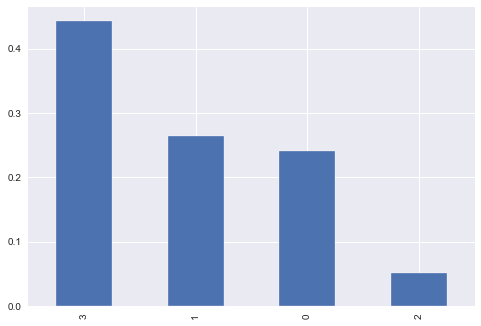

In [426]:
data_out['merged_labels'].value_counts(normalize=True).plot(kind='bar')
plt.show()

- 45% of the customers were reclassified as belonging to the cluster 3;
- ~25% belonging to the cluster 1 and cluster 0;
- the rest were classified as cluster 2;